# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.py
Benchmark.ipynb		tabs			VECM_TxPropria.html
Benchmark.pdf		Teste.ipynb		VECM_TxPropria.ipynb
Benchmark.Rmd		VECM_Infla.html		VECM_TxPropria_media.ipynb
Clean-checkpoint.ipynb	VECM_Infla.ipynb	VECM_TxPropria.pdf
Clean.ipynb		VECM_Infla_media.ipynb	VECM_TxPropria.py
figs			VECM_Infla.pdf


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
#start = datetime.datetime(1987, 1, 1)
start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

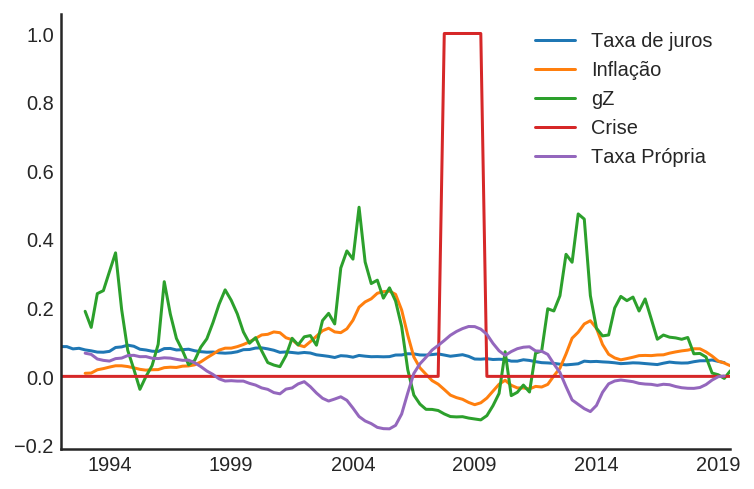

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.045446,0.080460,0.066893,0,-0.032406,0.002562,0.001012,-0.000151,0.002623
2018-09-30,0.045669,0.071268,0.056555,0,-0.023896,0.008511,-0.010338,-0.009192,0.000223
2018-12-31,0.047846,0.059207,0.009721,0,-0.010726,0.013170,-0.046833,-0.012061,0.002177
2019-03-31,0.043738,0.044789,0.004754,0,-0.001005,0.009720,-0.004968,-0.014418,-0.004108
2019-06-30,0.040108,0.038865,-0.006007,0,0.001196,0.002201,-0.010761,-0.005924,-0.003631


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('Q').mean()
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"], *_ = yeojohnson(df["Preço dos imóveis"].pct_change(4)) ### Warning

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
#df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria']) # Warning

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        rank_sel = select_coint_rank(endog=series, k_ar_diff=i, det_order=0).rank  ### Warning
        print(f'Para lag = {i}, Rank = {rank_sel}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            58   
m = 2         50 65   
m = 3   15    50 65   
m = 4   15 30 50 65   
m = 5   15 30 50 65 80

Corresponding to breakdates:
                                               
m = 1                           2001(2)        
m = 2                   1999(2) 2003(1)        
m = 3   1990(3)         1999(2) 2003(1)        
m = 4   1990(3) 1994(2) 1999(2) 2003(1)        
m = 5   1990(3) 1994(2) 1999(2) 2003(1) 2006(4)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.533   5.957   3.733   3.733   3.733   3.733
BIC  15.695  15.315 -24.448 -15.140  -5.832   3.475
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

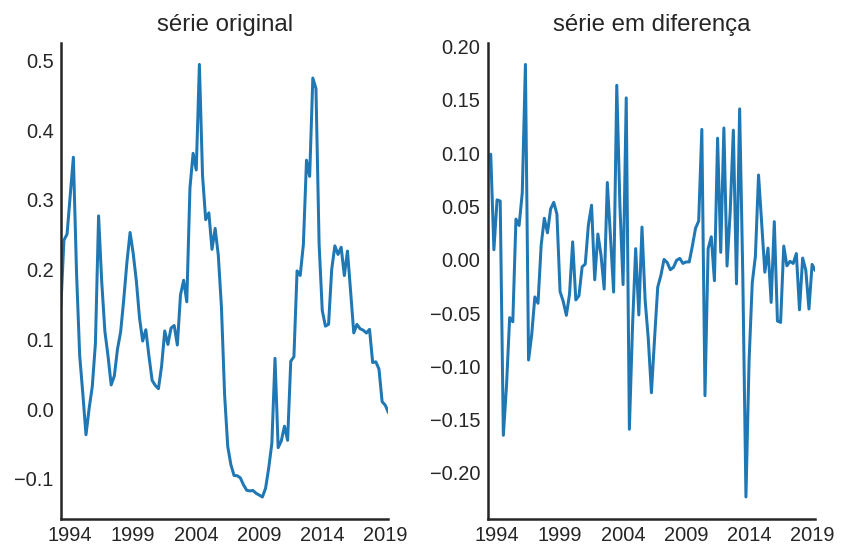

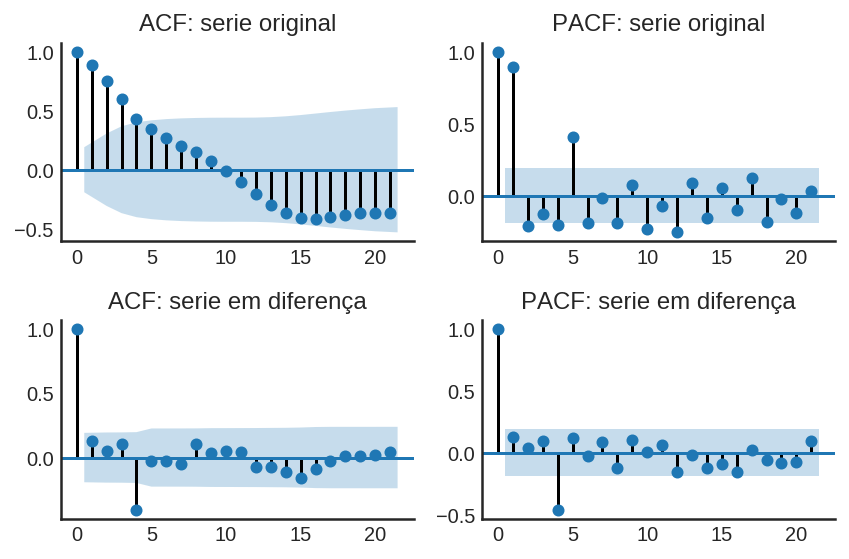


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.670
P-value                         0.568
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.628
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.849
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

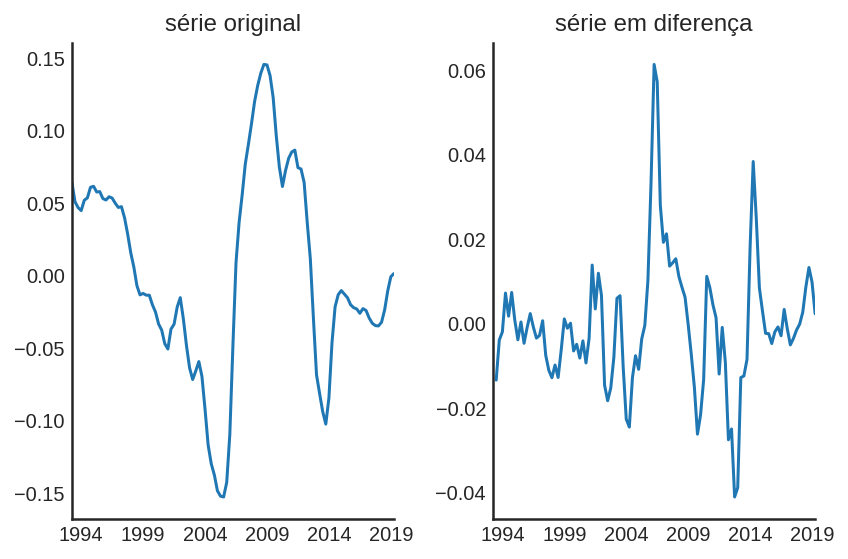

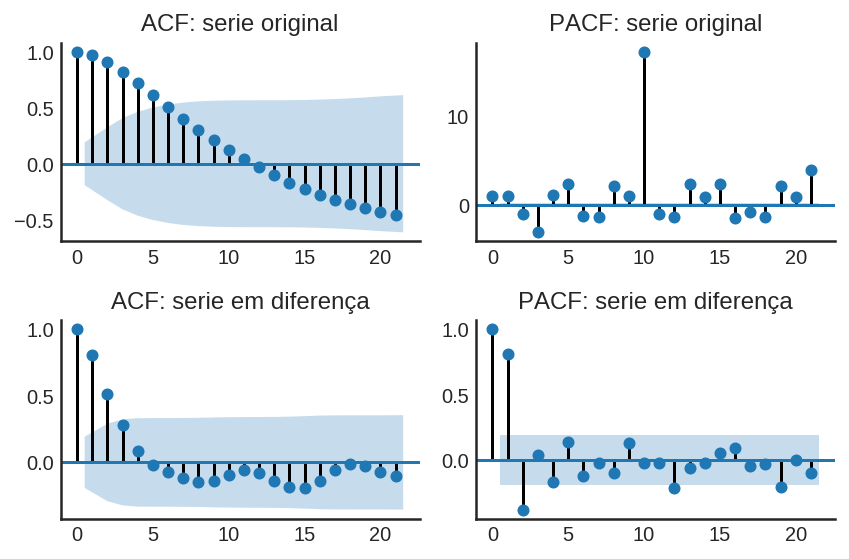


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.168
P-value                         0.017
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -4.520
P-value                         0.113
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.704
P-value 

In [11]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

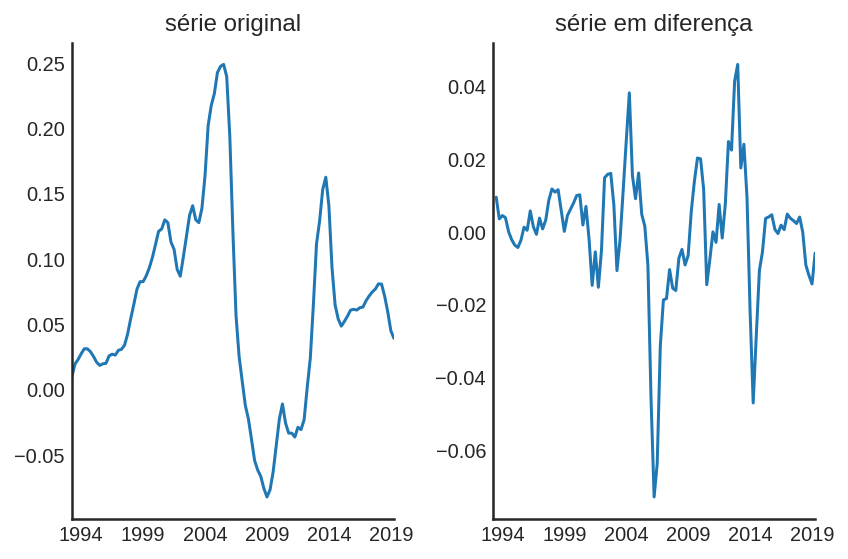

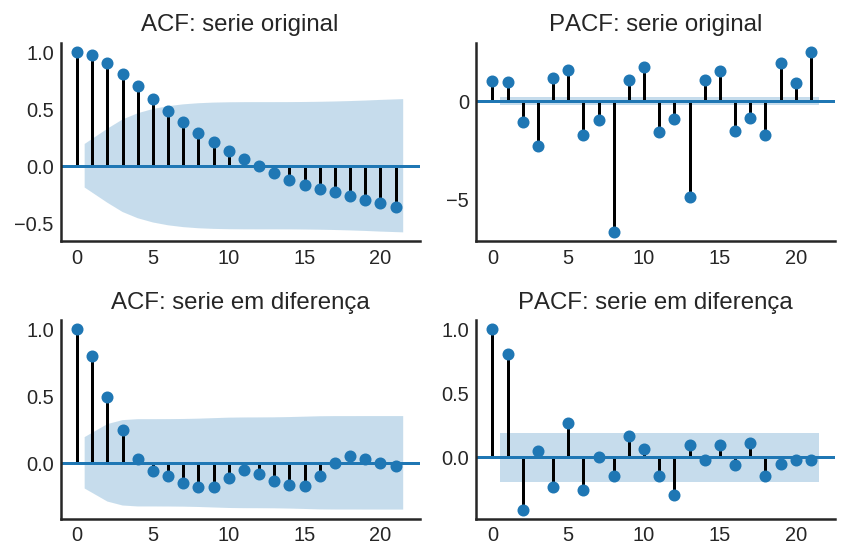


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.442
P-value                         0.005
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -4.509
P-value                         0.117
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.836
P-value 

In [12]:
testes_raiz(df['Inflação'], diff_trend='c')

## Taxa de juros das hipotecas

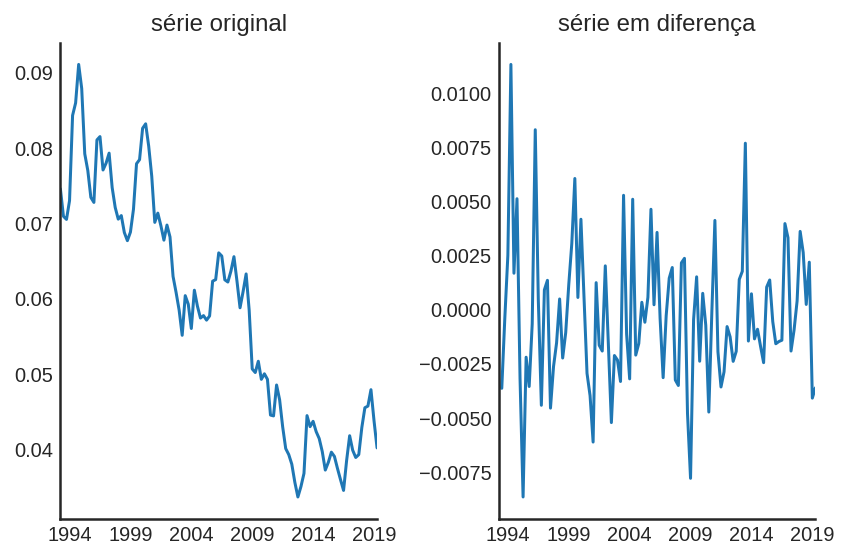

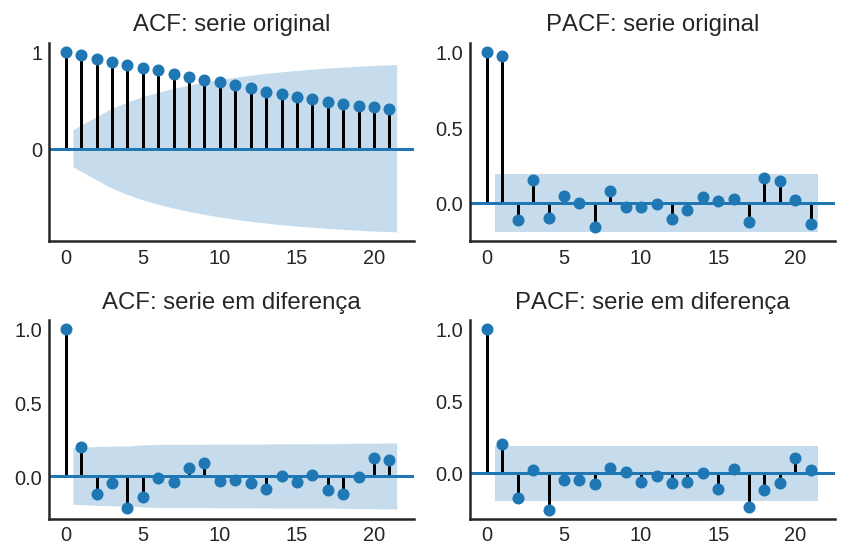


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.298
P-value                         0.025
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.625
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.287166
p-value: 0.141938
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.588566
p-value: 0.025311
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.627923
p-value: 0.073589
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.581576
p-value: 0.185105
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para l

## $g_Z$, Inflação e taxa de juros

In [15]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.507599
p-value: 0.028630
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.550502
p-value: 0.079881
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.731055
p-value: 0.007956
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.623608
p-value: 0.000940
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 1

Testando para lag = 2 e trend = nc
Nu

## $g_Z$ e Inflação

In [16]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.524294
p-value: 0.005671
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.521088
p-value: 0.030571
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.503850
p-value: 0.098436
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.448915
p-value: 0.236193
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Para lag = 1, Rank = 2

Testando para lag = 2 e tr

# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'cili'
order_vec = select_order(
    df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-14.26,-13.93,6.389e-07,-14.13
1,-14.99,-14.54*,3.094e-07,-14.81
2,-15.03,-14.47,2.988e-07,-14.80
3,-15.06,-14.39,2.890e-07,-14.79
4,-15.15,-14.36,2.656e-07,-14.83*
5,-15.18*,-14.28,2.587e-07*,-14.81
6,-15.11,-14.10,2.782e-07,-14.70
7,-15.03,-13.92,3.002e-07,-14.58
8,-15.06,-13.83,2.940e-07,-14.56
9,-15.02,-13.67,3.091e-07,-14.48


## Estimação

In [18]:
model = VECM(
    endog = df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    k_ar_diff=5,
    deterministic=det
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

## Análise dos resíduos

Det. terms outside the coint. relation & lagged endog. parameters for equation Inflação
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1          -0.1432      0.142     -1.011      0.312      -0.421       0.135
L1.Inflação     1.1251      0.103     10.891      0.000       0.923       1.328
L1.gZ           0.0354      0.017      2.085      0.037       0.002       0.069
L2.Inflação    -0.6622      0.151     -4.389      0.000      -0.958      -0.366
L2.gZ           0.0168      0.015      1.088      0.276      -0.013       0.047
L3.Inflação     0.4090      0.160      2.553      0.011       0.095       0.723
L3.gZ           0.0267      0.015      1.762      0.078      -0.003       0.056
L4.Inflação    -0.4726      0.153     -3.091      0.002      -0.772      -0.173
L4.gZ          -0.0082      0.015     -0.534      0.594      -0.039       0.022
L5.Inflação     0.2140      0.09

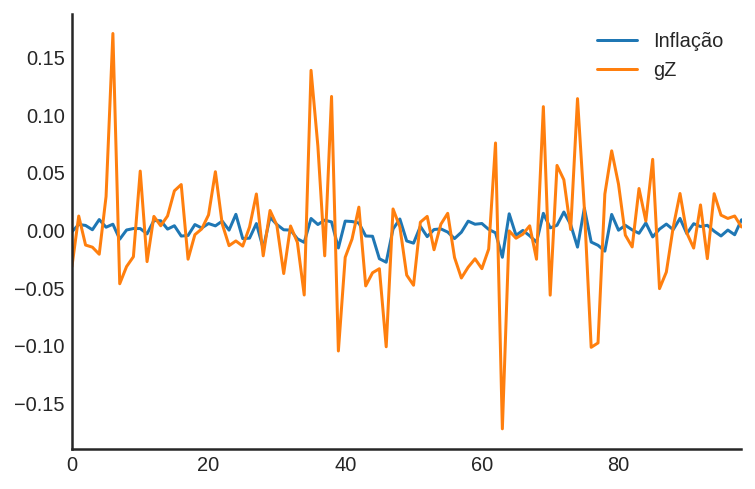

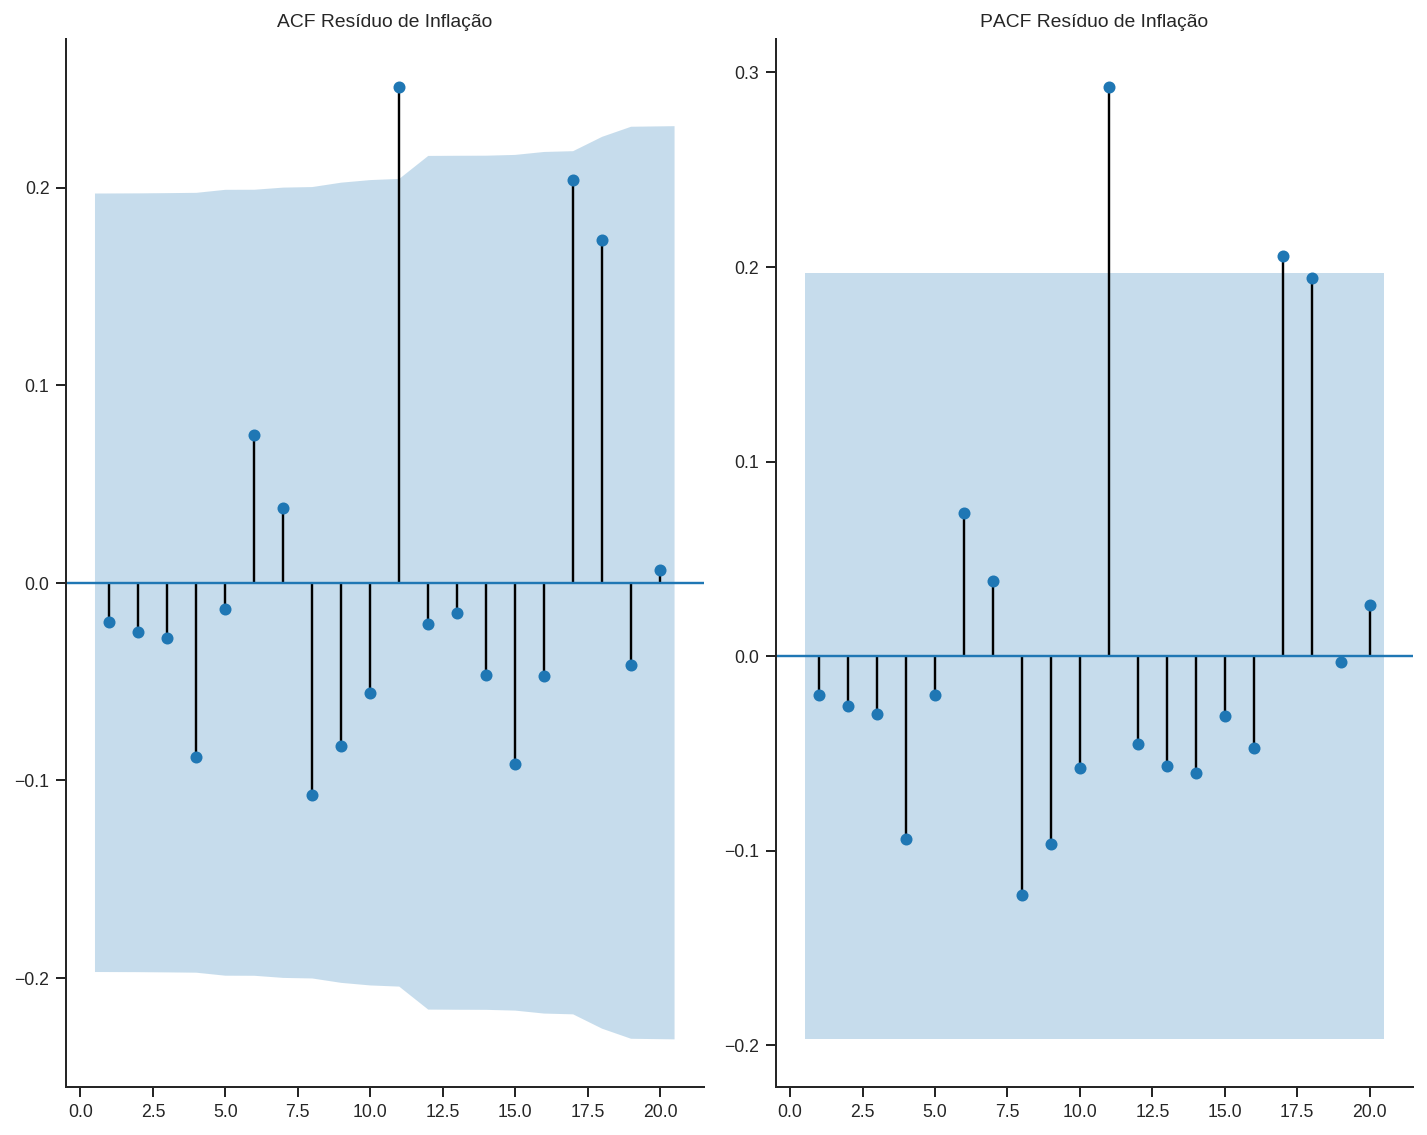

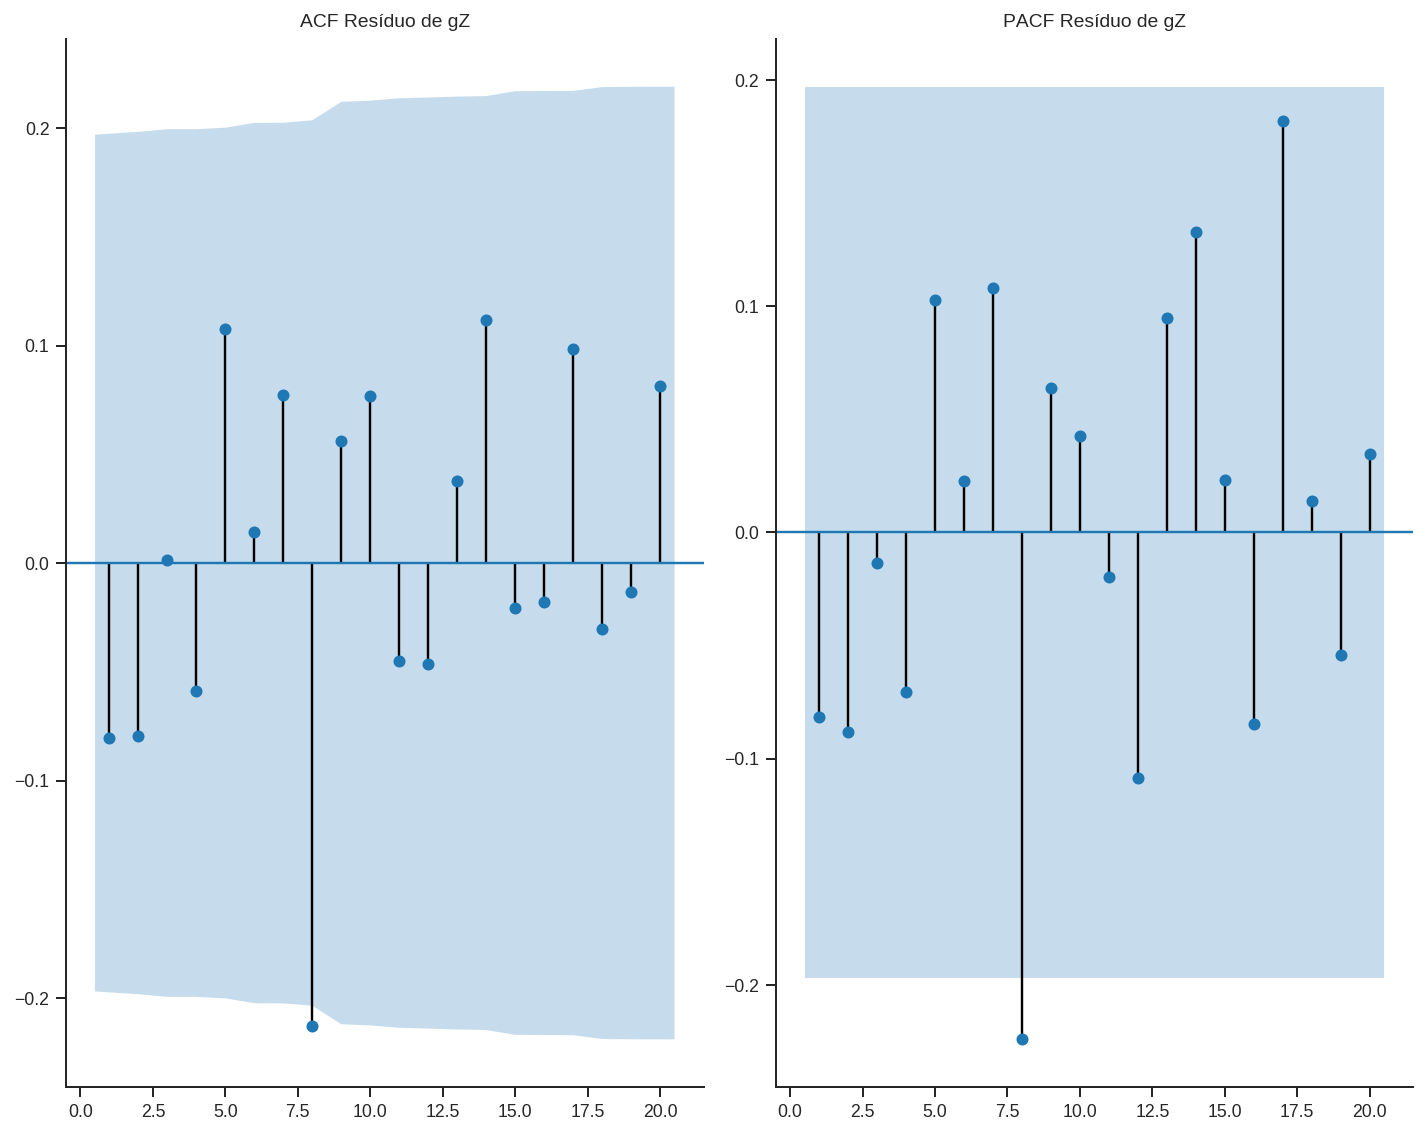

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         56.31          53.38   0.028 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         62.60          53.38   0.007 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  False
Reject H0 on

In [19]:
print(results.summary())
print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

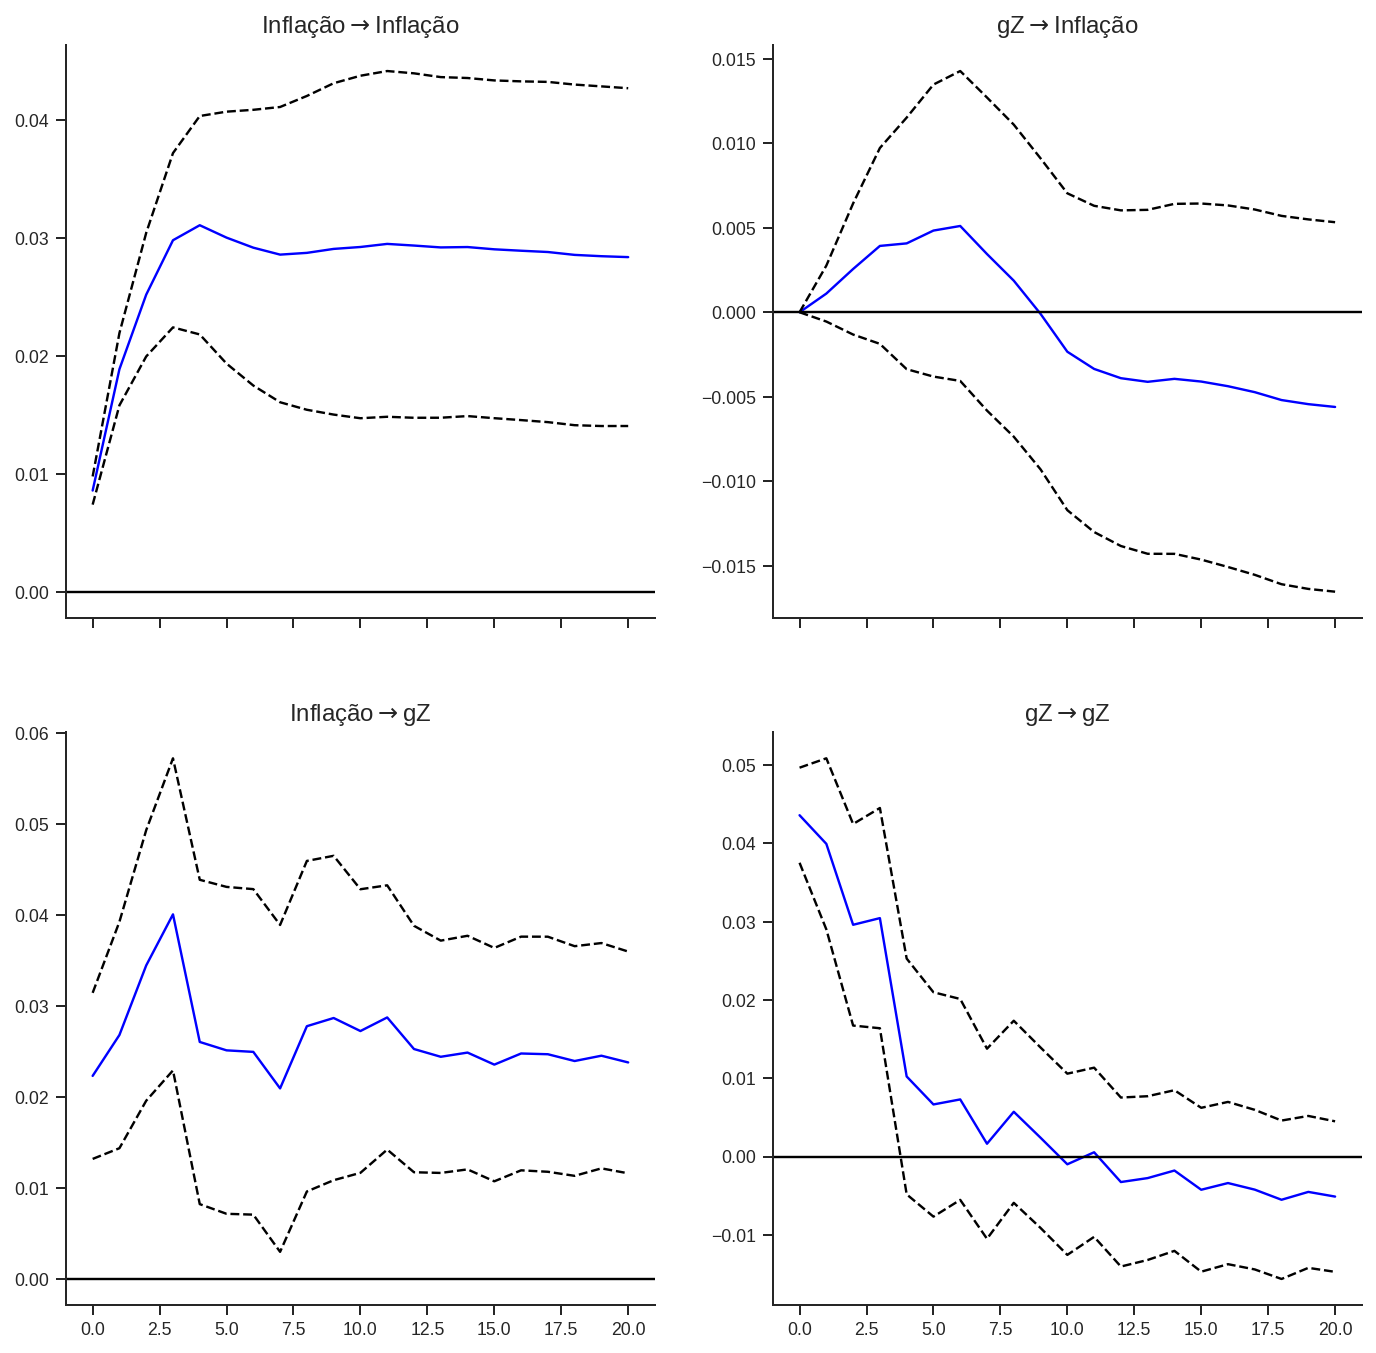

In [20]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

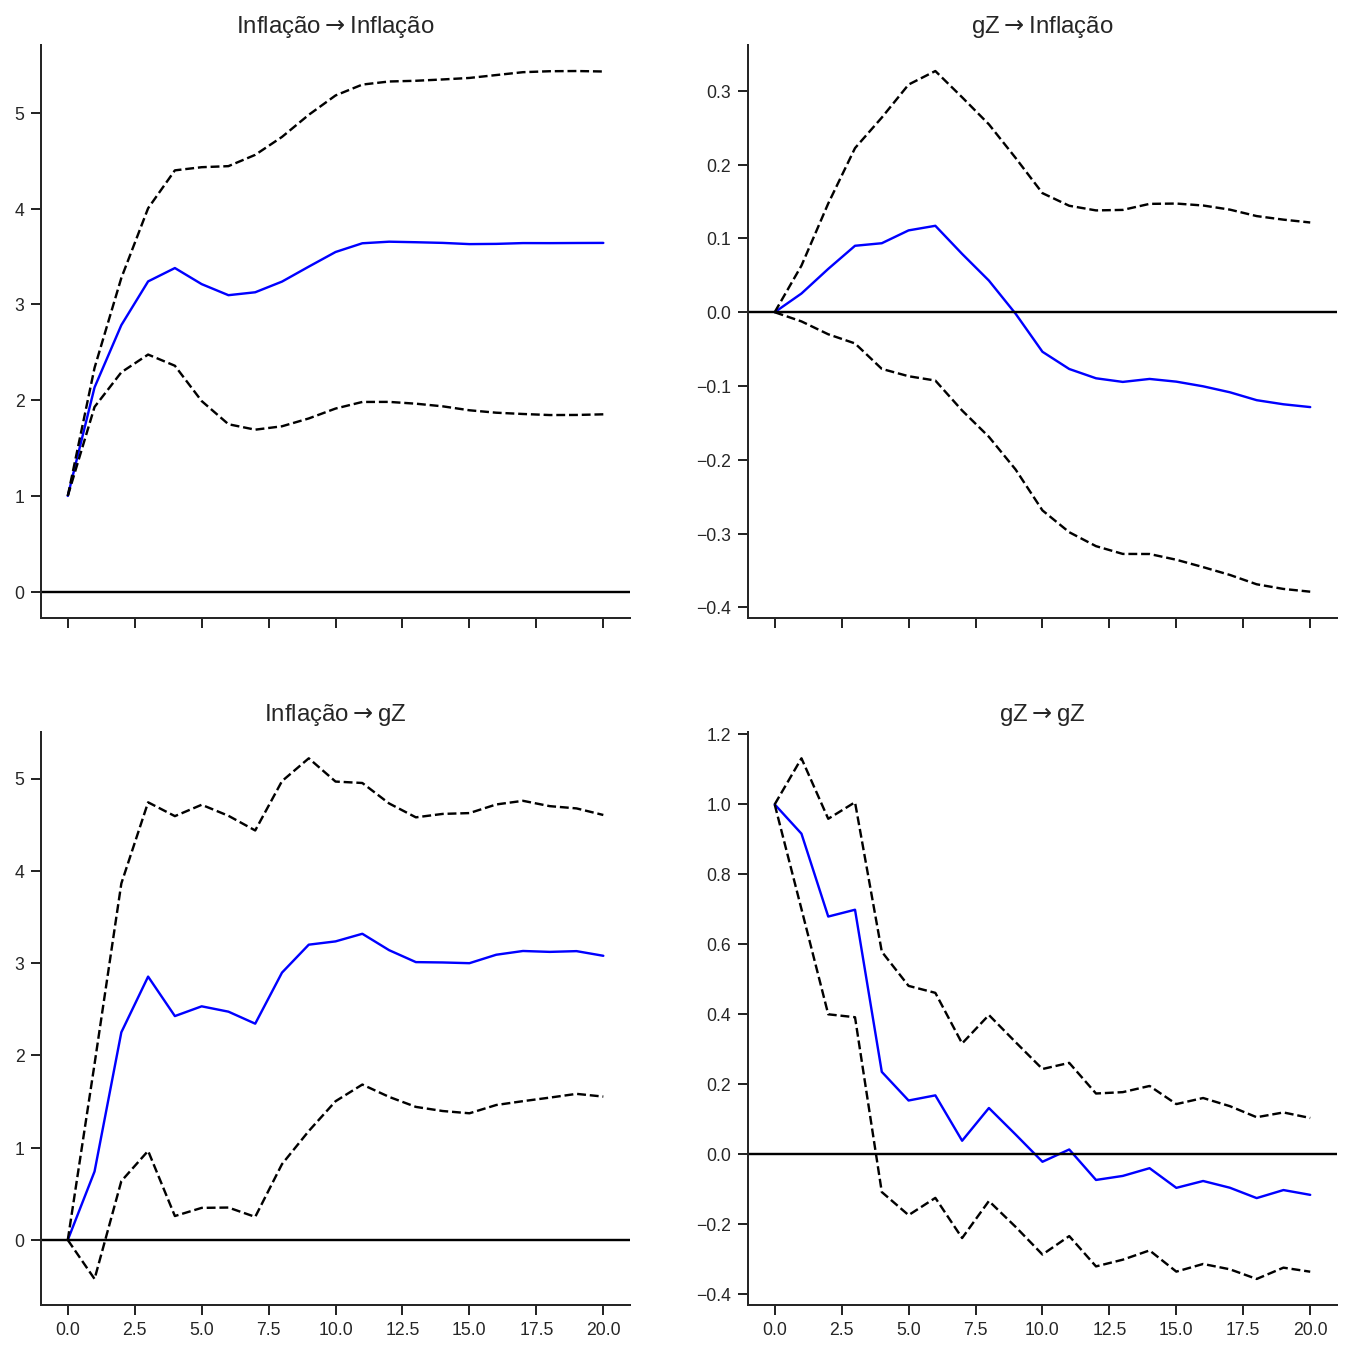

In [21]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# Teste de causalidade de granger

In [22]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Inflação does not Granger-cause gZ. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.119          2.155   0.354 (6, 162)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Inflação does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         16.91          3.841   0.000  1
----------------------------------------


## Inspeção gráfica dos resíduos

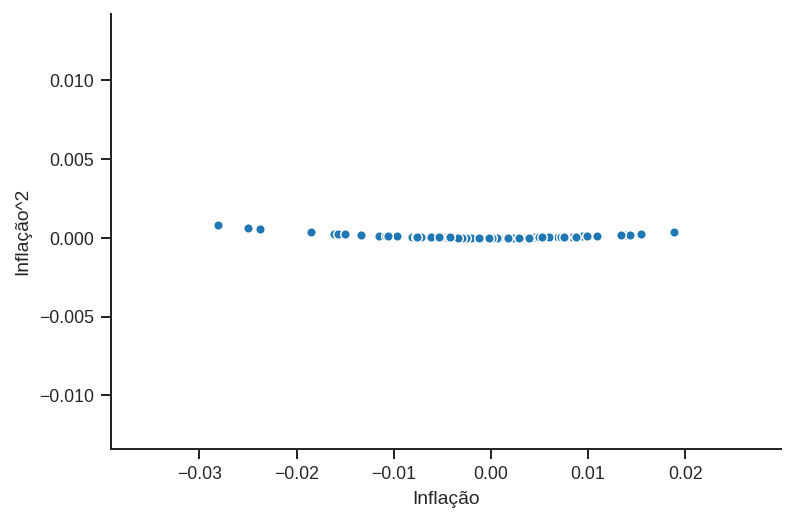

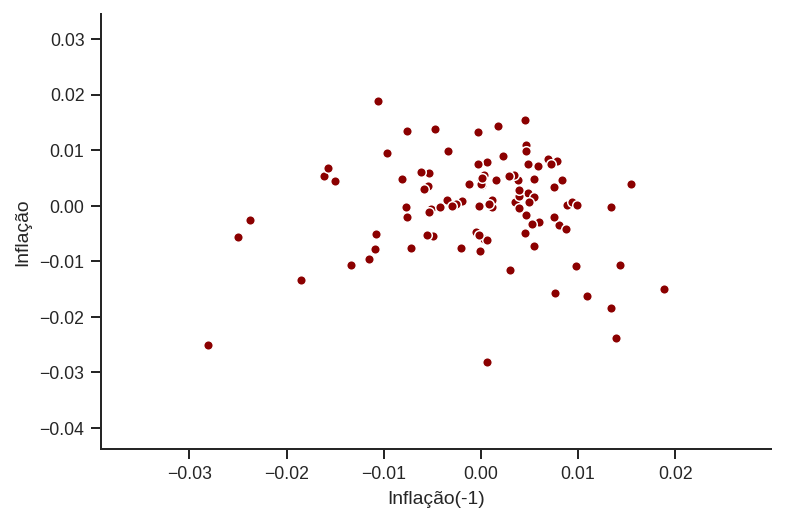

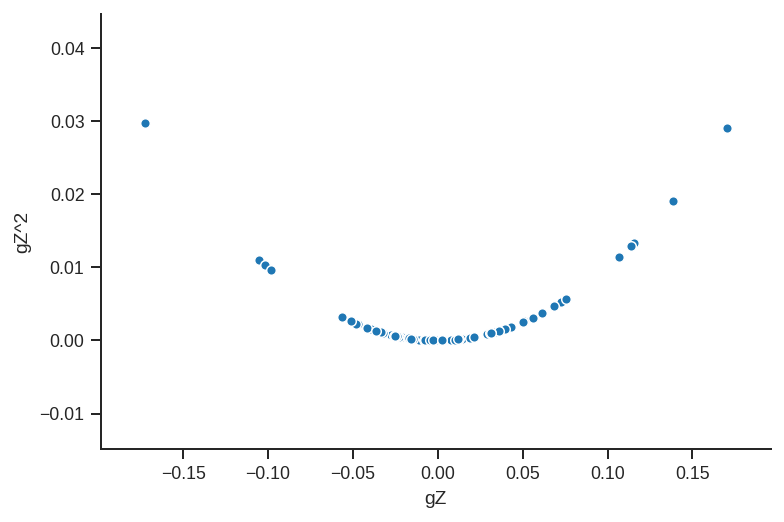

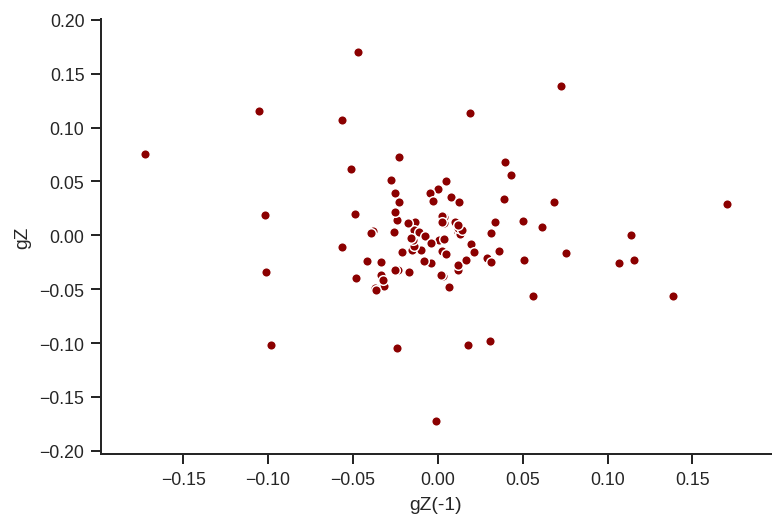

In [23]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

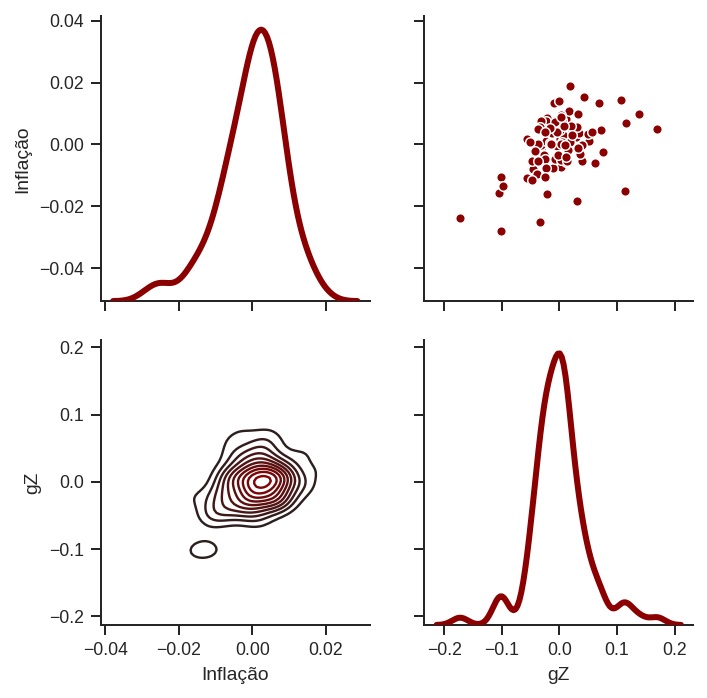

In [24]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

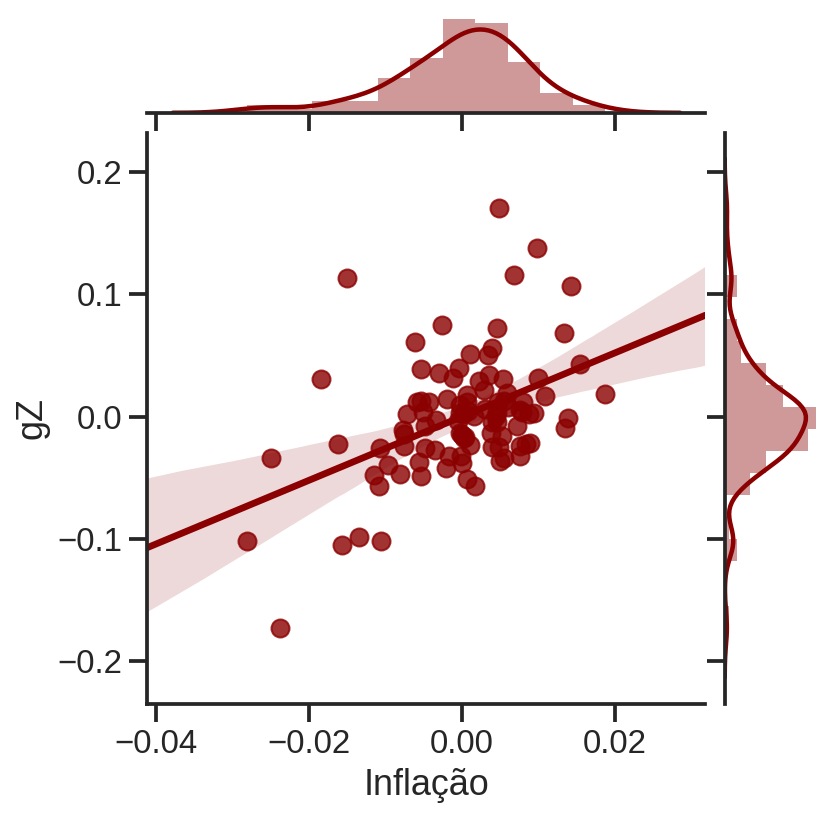

In [25]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

In [26]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("Infla","gZ")], lag = 4, r = 1, estim = "ML", LRinclude="both", include="trend", exogen = coredata(df[,"Juros"]))
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [27]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$Infla)

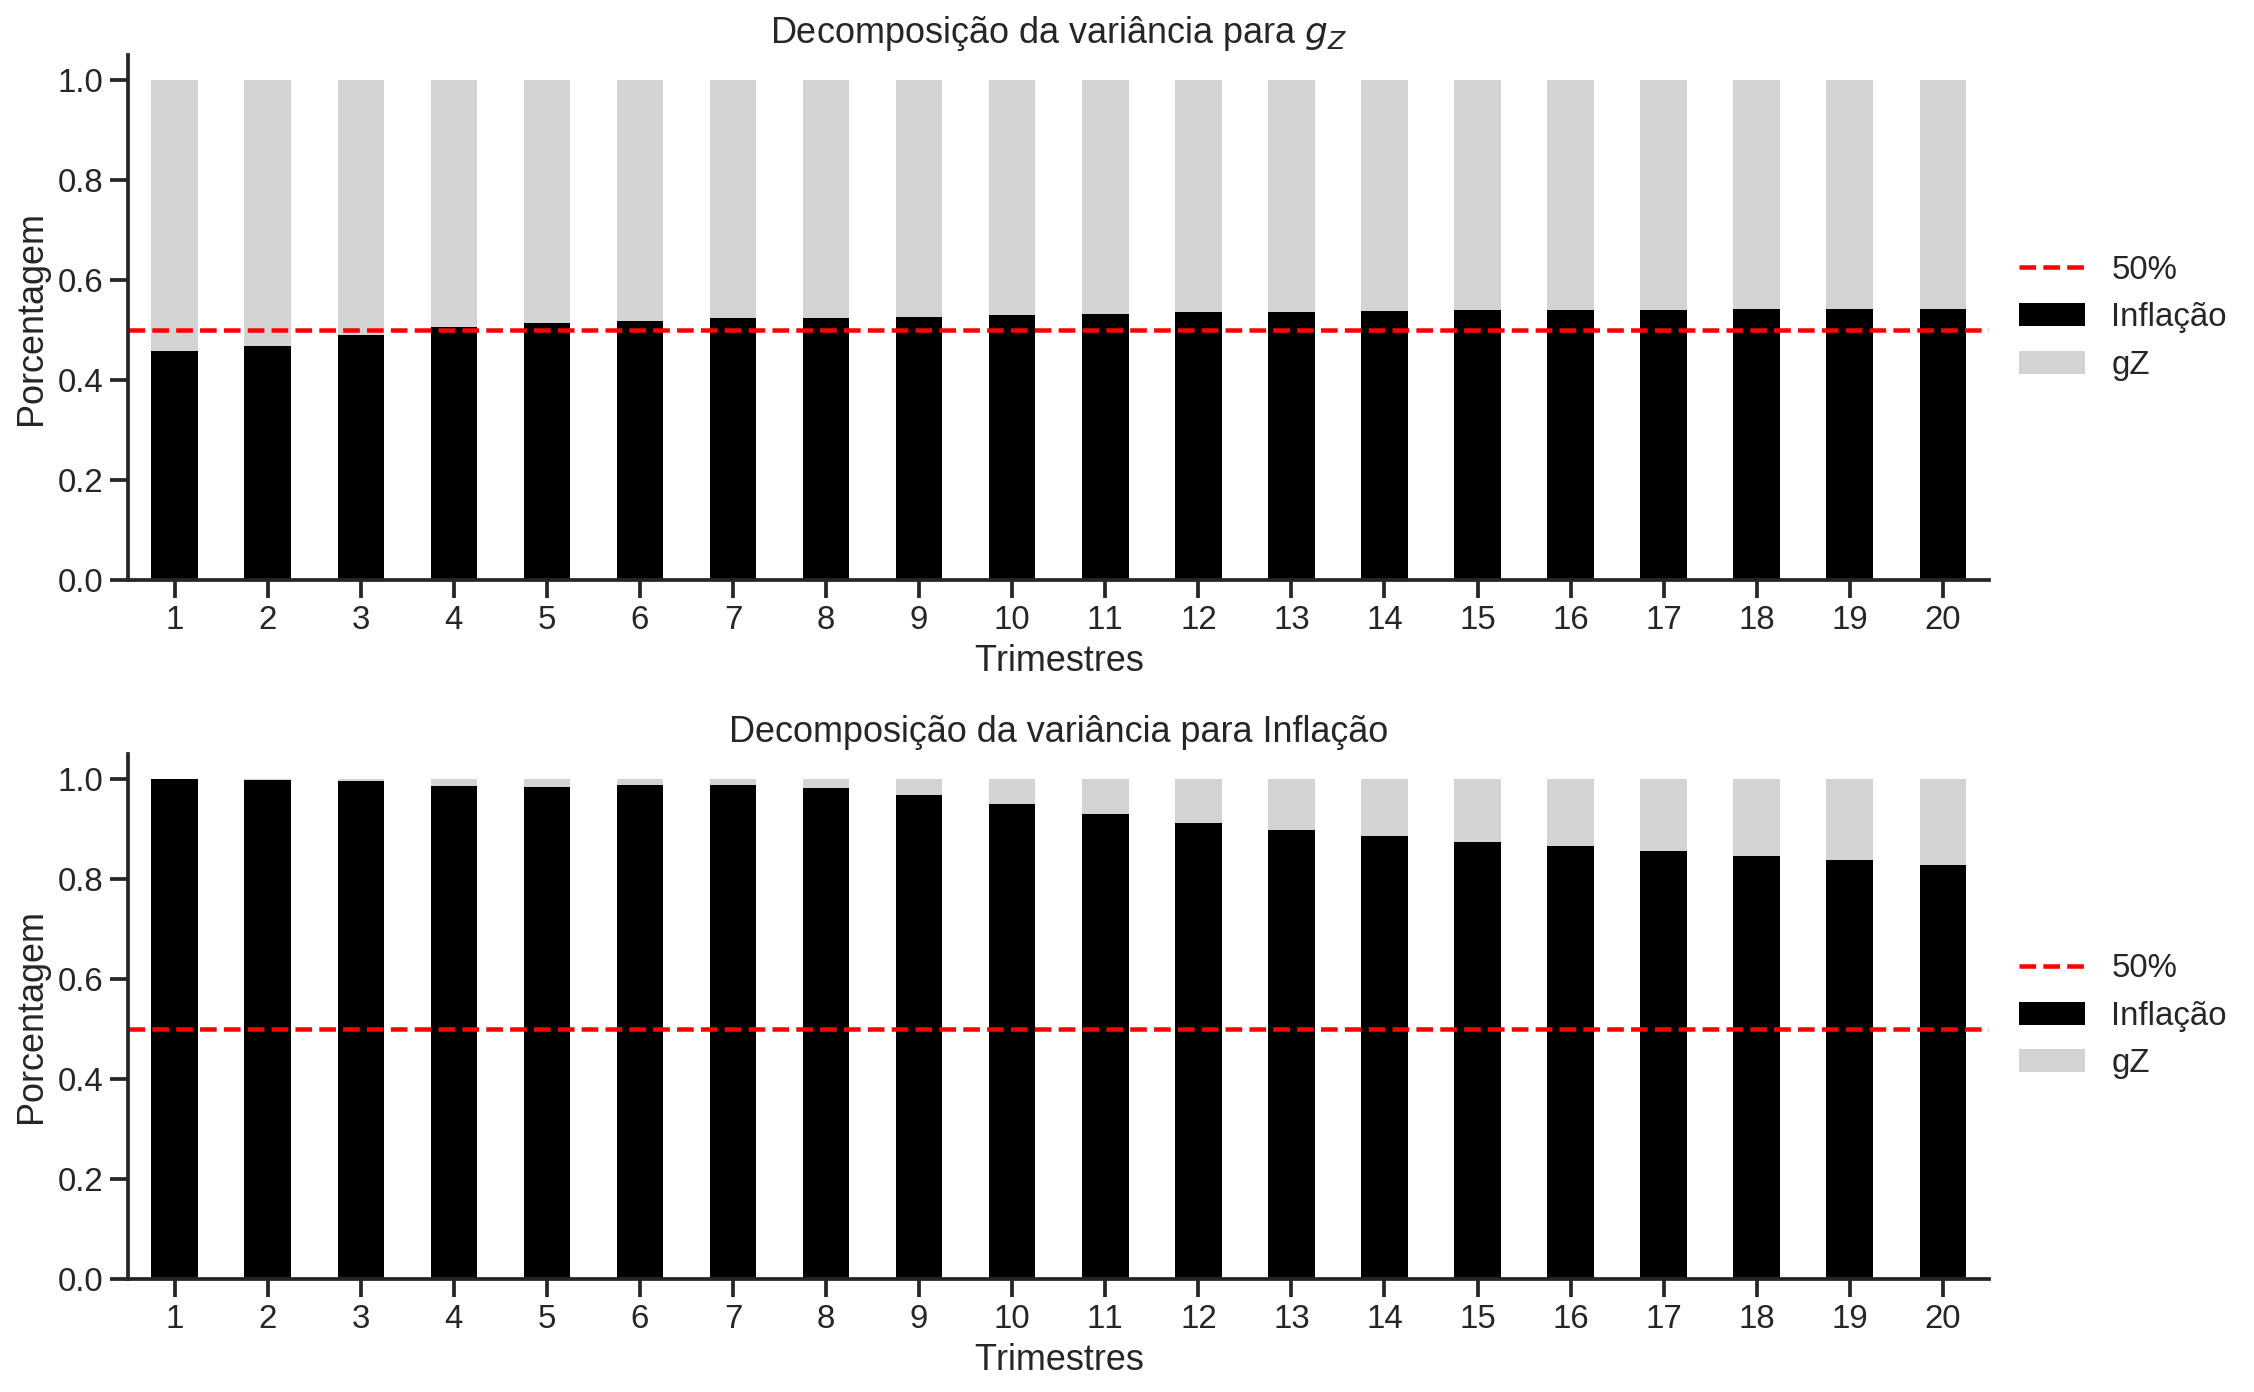

In [28]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [29]:
model = VAR(
    df[["d_Inflação", 'd_gZ']],
    exog=df['Taxa de juros']
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.84      -13.67   9.768e-07      -13.77
1       -14.77     -14.49*   3.841e-07      -14.66
2       -14.83      -14.44   3.640e-07      -14.67
3       -14.89      -14.39   3.409e-07      -14.69
4       -15.02      -14.41   2.993e-07      -14.78
5      -15.11*      -14.38  2.759e-07*     -14.82*
6       -15.07      -14.24   2.865e-07      -14.74
7       -14.99      -14.05   3.103e-07      -14.61
8       -15.05      -13.99   2.952e-07      -14.62
9       -15.03      -13.87   3.015e-07      -14.56
10      -14.99      -13.71   3.161e-07      -14.48
11      -14.93      -13.54   3.389e-07      -14.37
12      -14.99      -13.49   3.224e-07      -14.38
13      -14.91      -13.30   3.501e-07      -14.26
14      -14.91      -13.19   3.536e-07      -14.22
15      -14.90      -13.06   3.641e-07      -14.16
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [30]:
results = model.fit(maxlags=8)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           dom, 08, dez, 2019
Time:                     14:41:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.9626
Nobs:                     97.0000    HQIC:                  -14.5318
Log likelihood:           484.255    FPE:                3.34900e-07
AIC:                     -14.9181    Det(Omega_mle):     2.38267e-07
--------------------------------------------------------------------
Results for equation d_Inflação
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000985         0.003963           -0.249           0.804
exog0                 0.027028         0.068549            0.394           0.693
L1.d_Inflação         1.064852         0.125614        

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

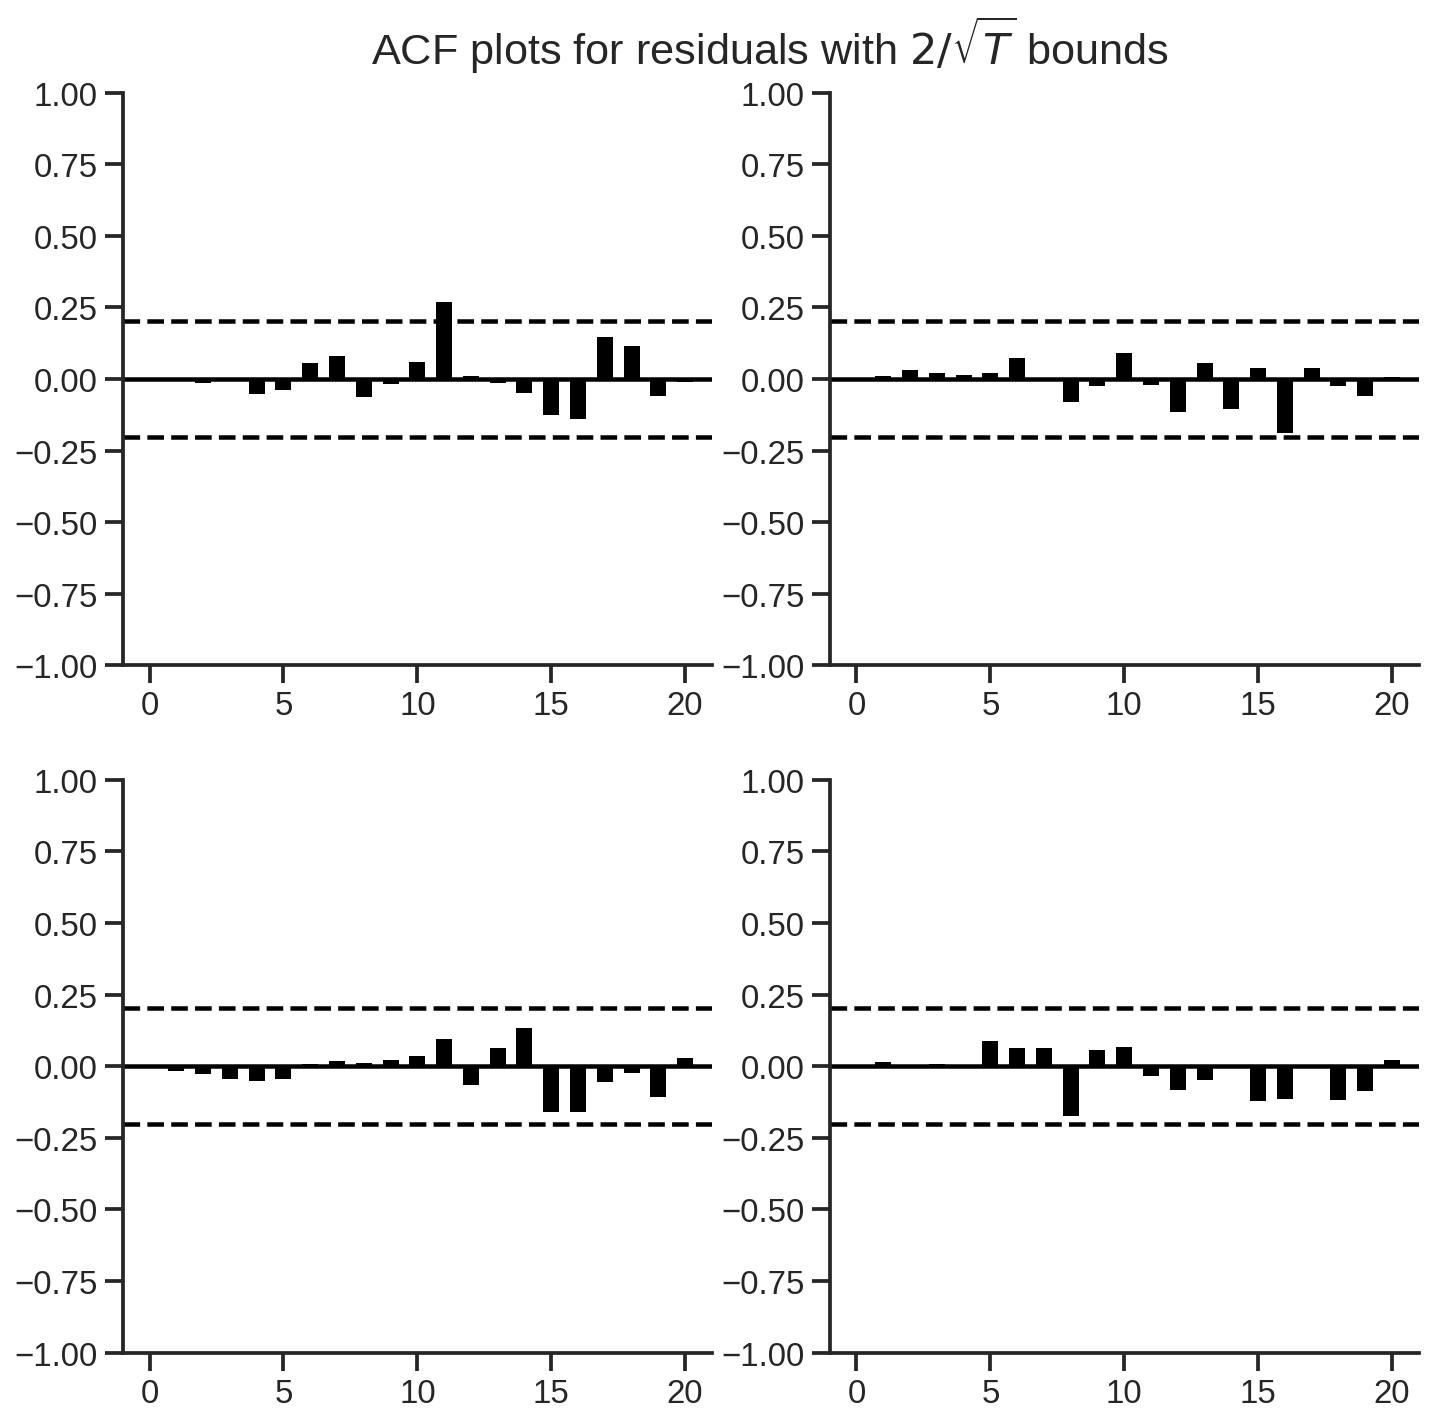

In [31]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [32]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8532819657342356
0.8532819657342356
0.8152000188895515
0.8152000188895515
0.8098265866778618
0.8098265866778618
0.7286157793436967
0.7286157793436967
0.8337349915755229
0.8337349915755229
0.843810655018837
0.843810655018837
0.7165972792536248
0.7165972792536248
0.43058420290617494
0.43058420290617494
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

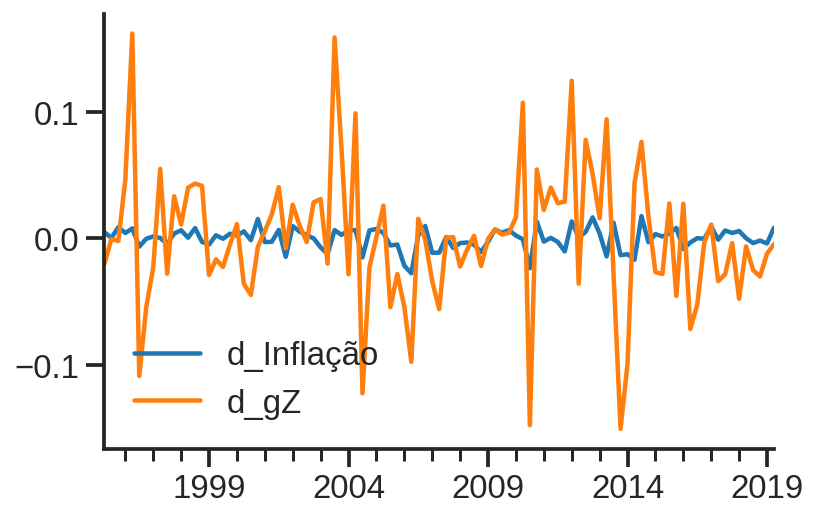

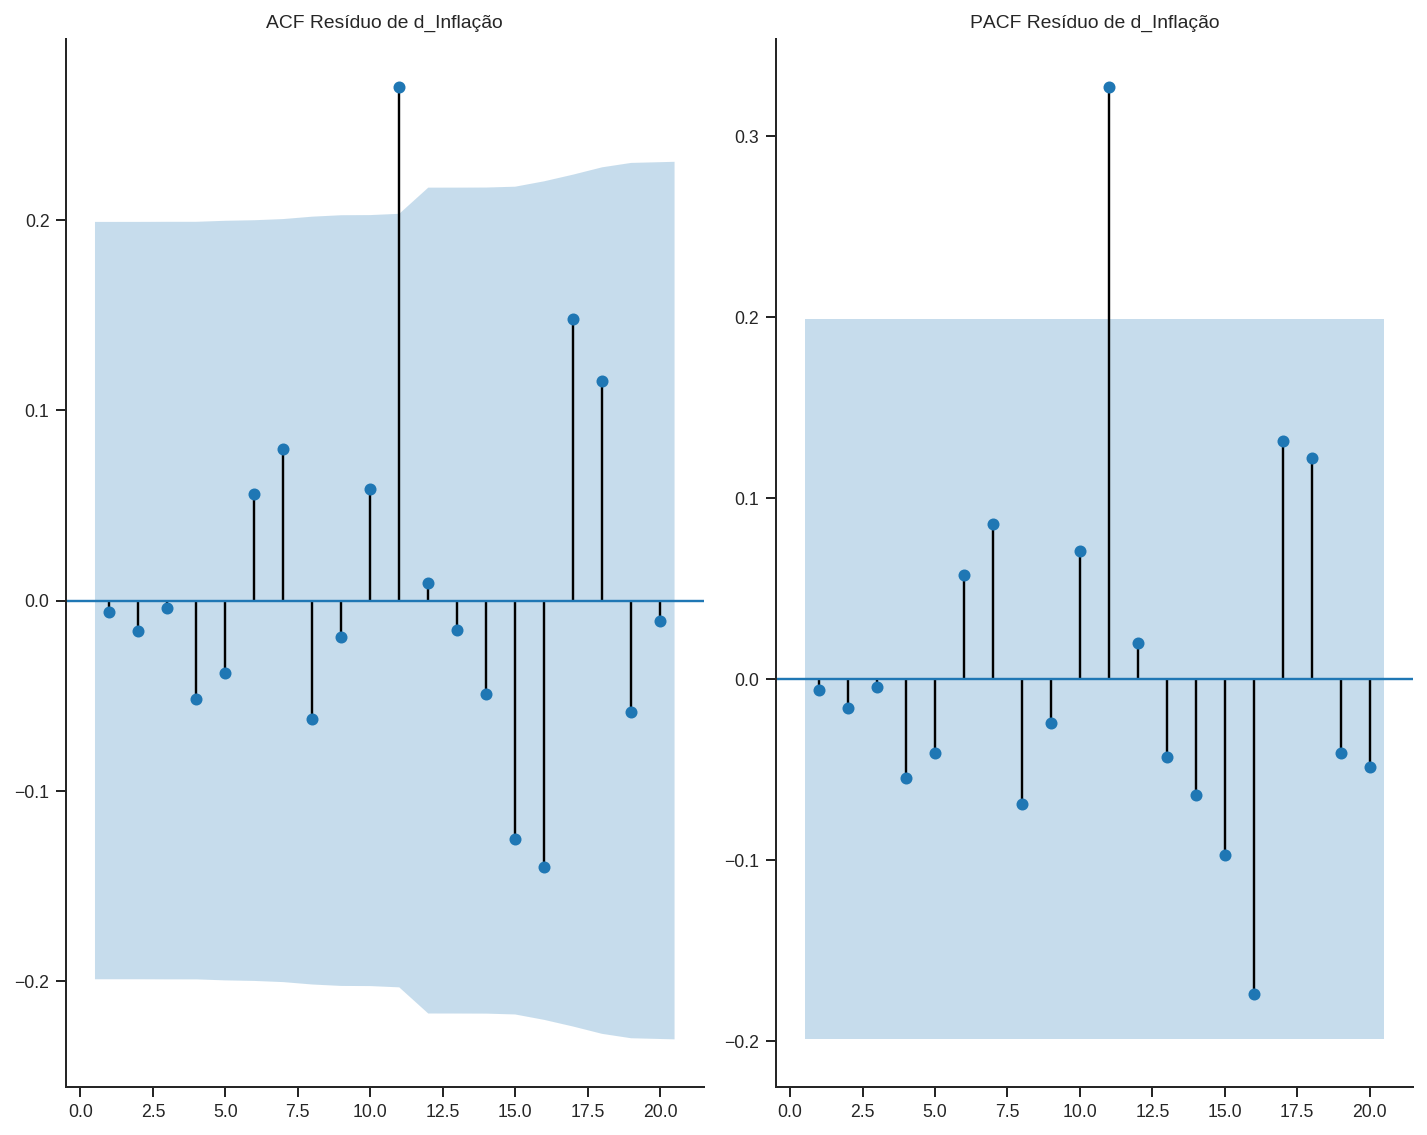

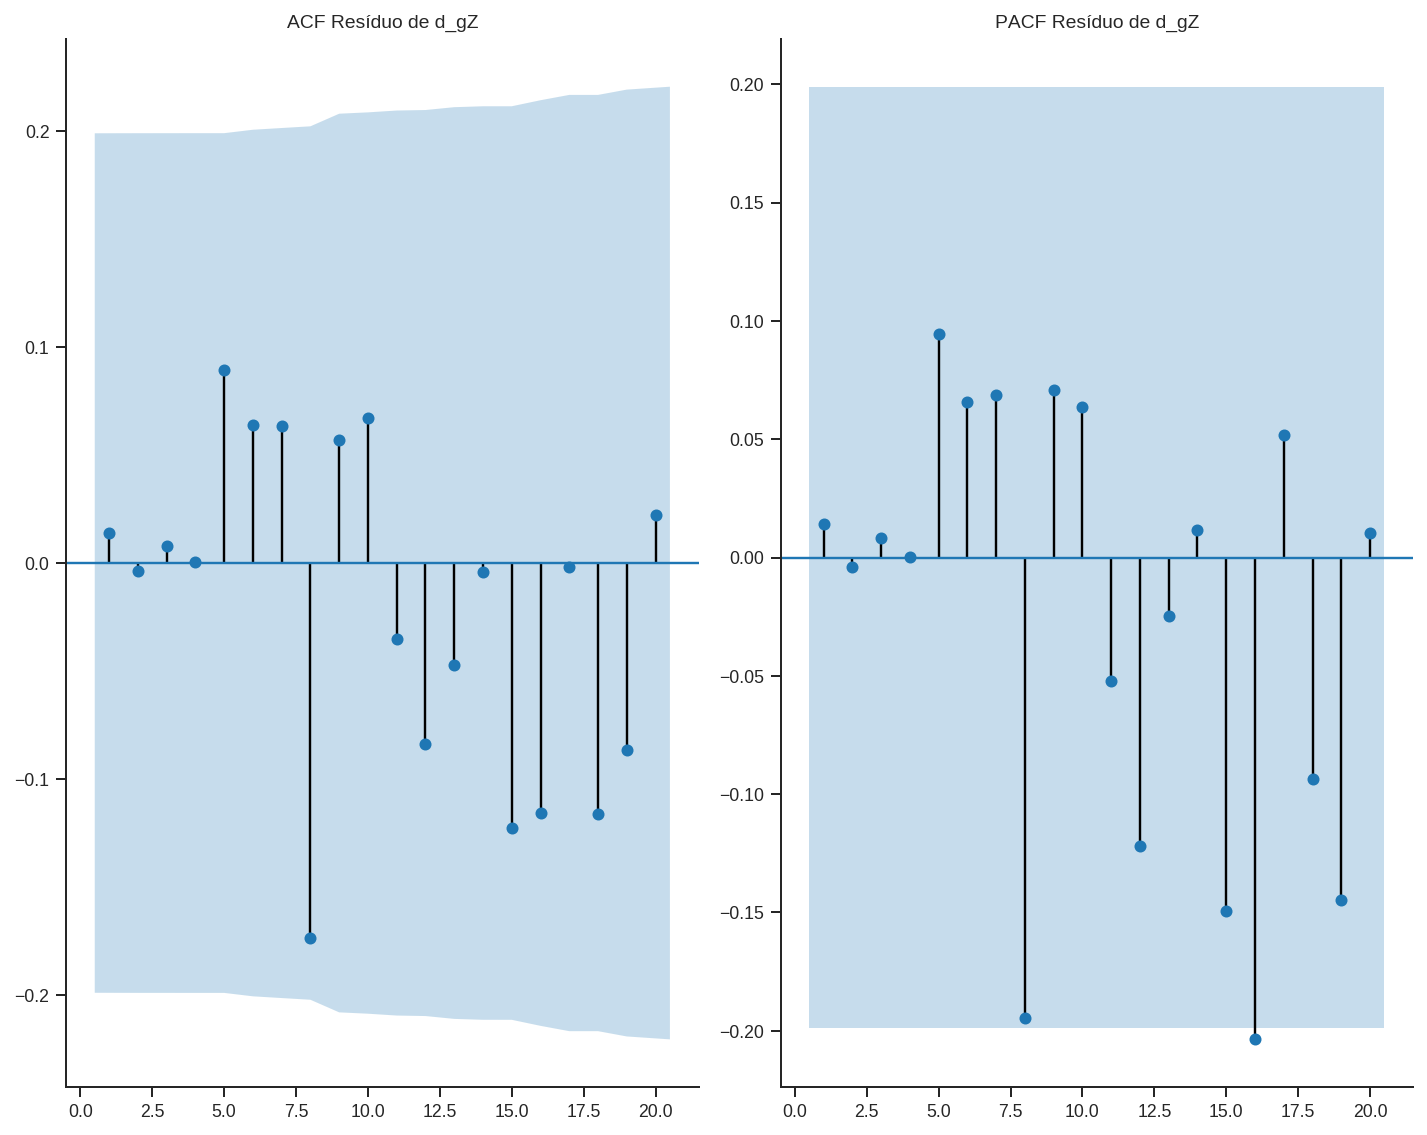

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         37.18          41.34   0.115 28
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         41.91          41.34   0.044 28
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  False
Re

In [33]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

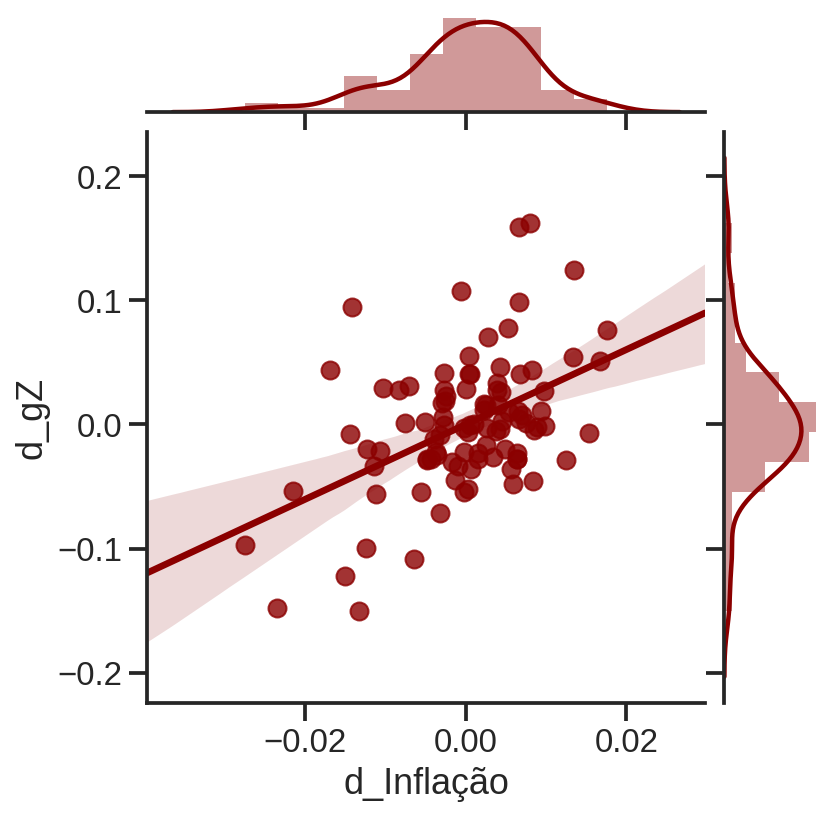

In [34]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

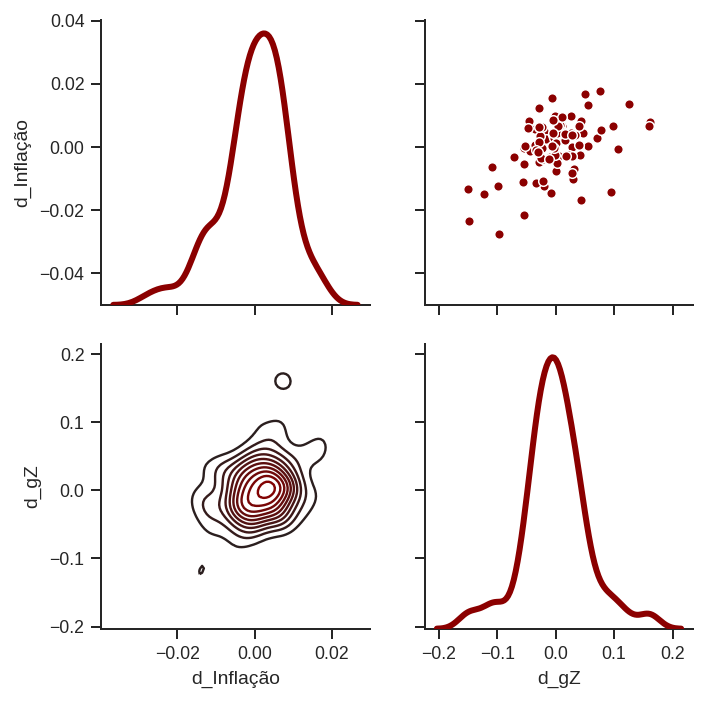

In [35]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

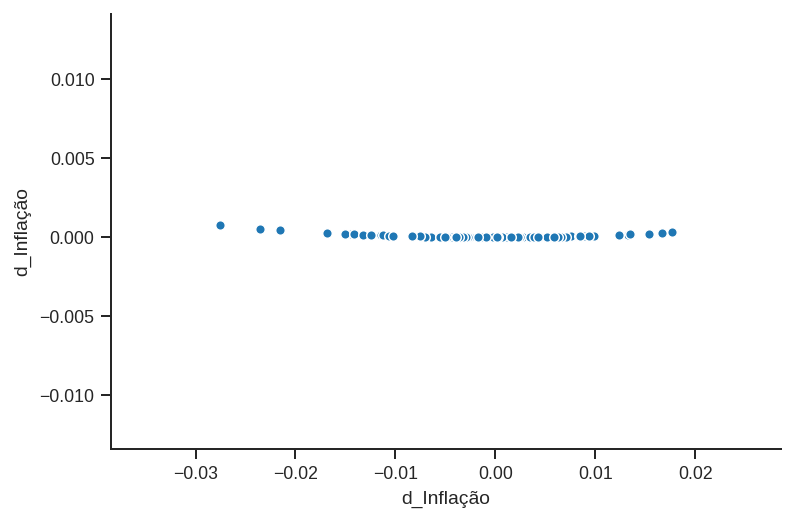

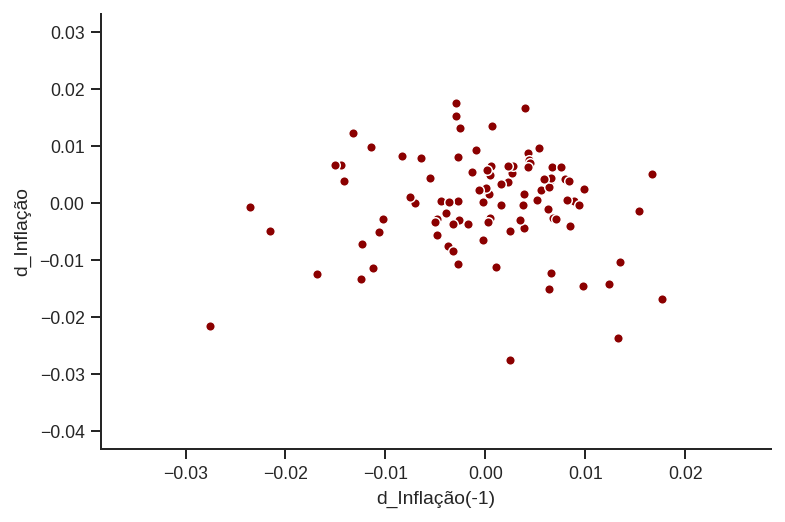

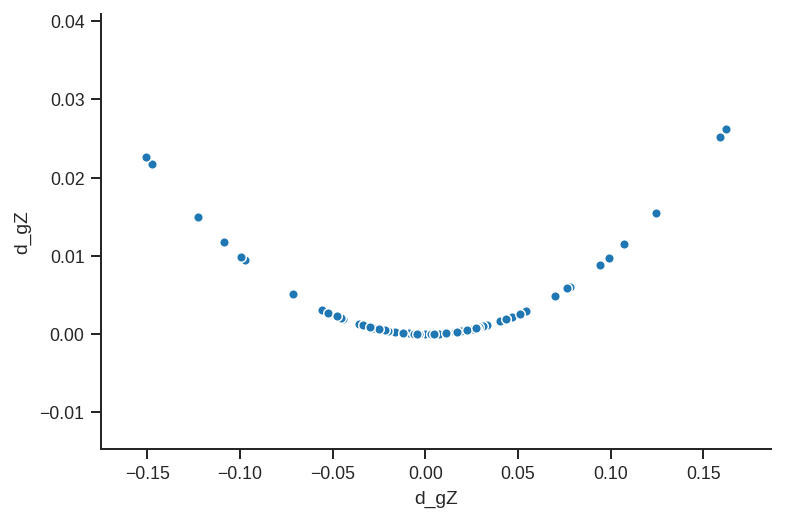

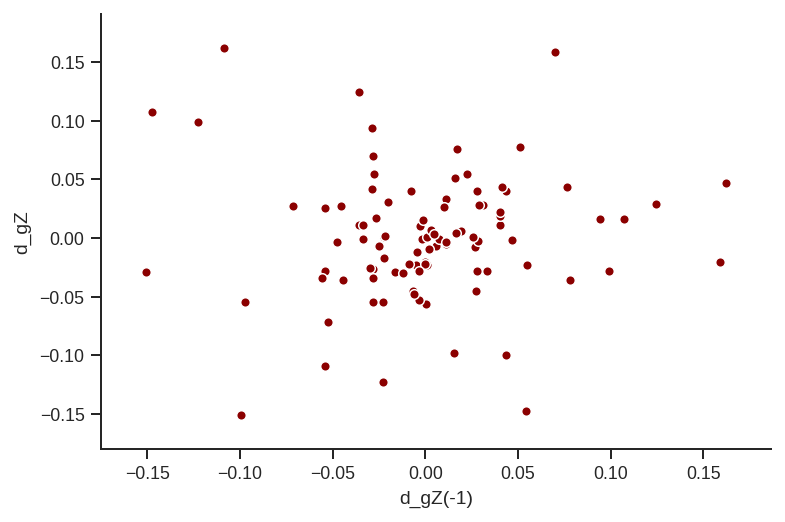

In [36]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

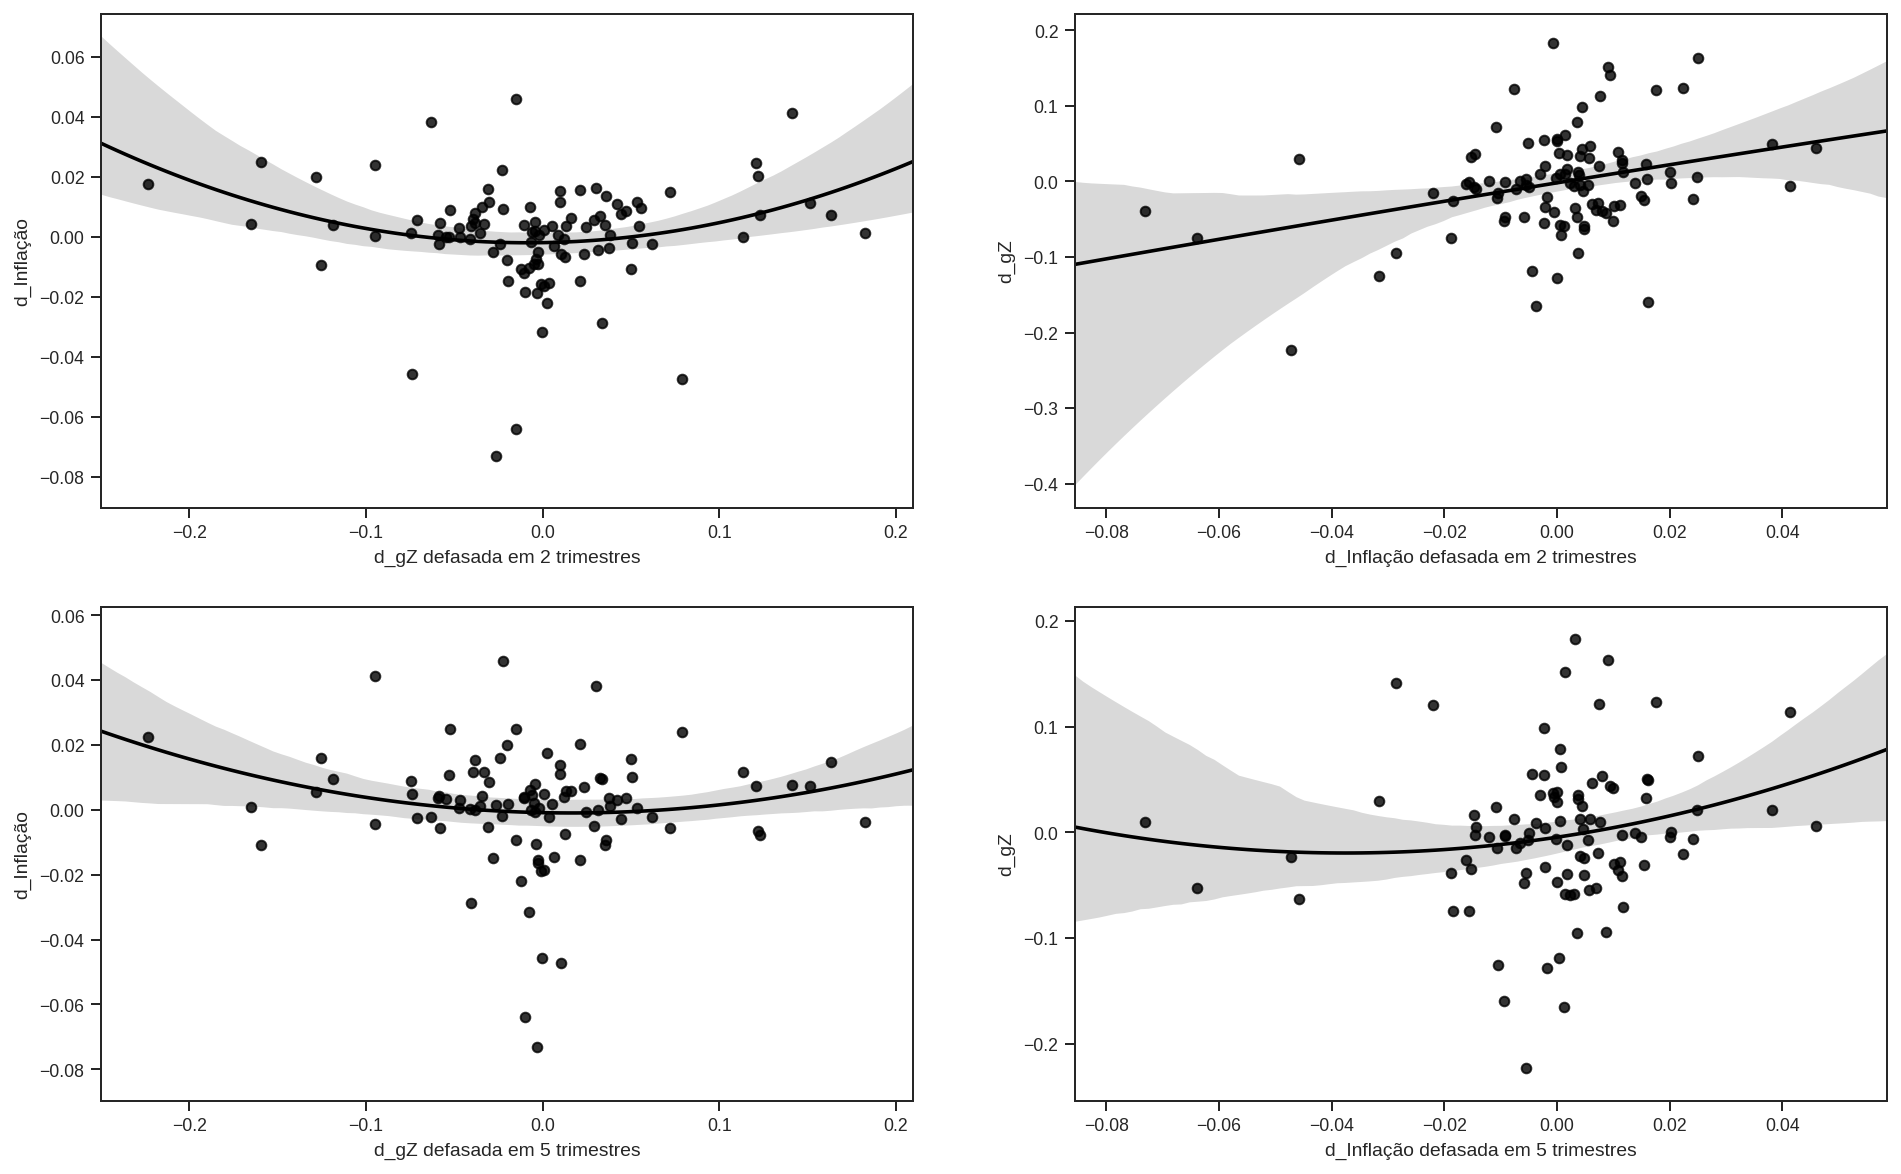

In [37]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

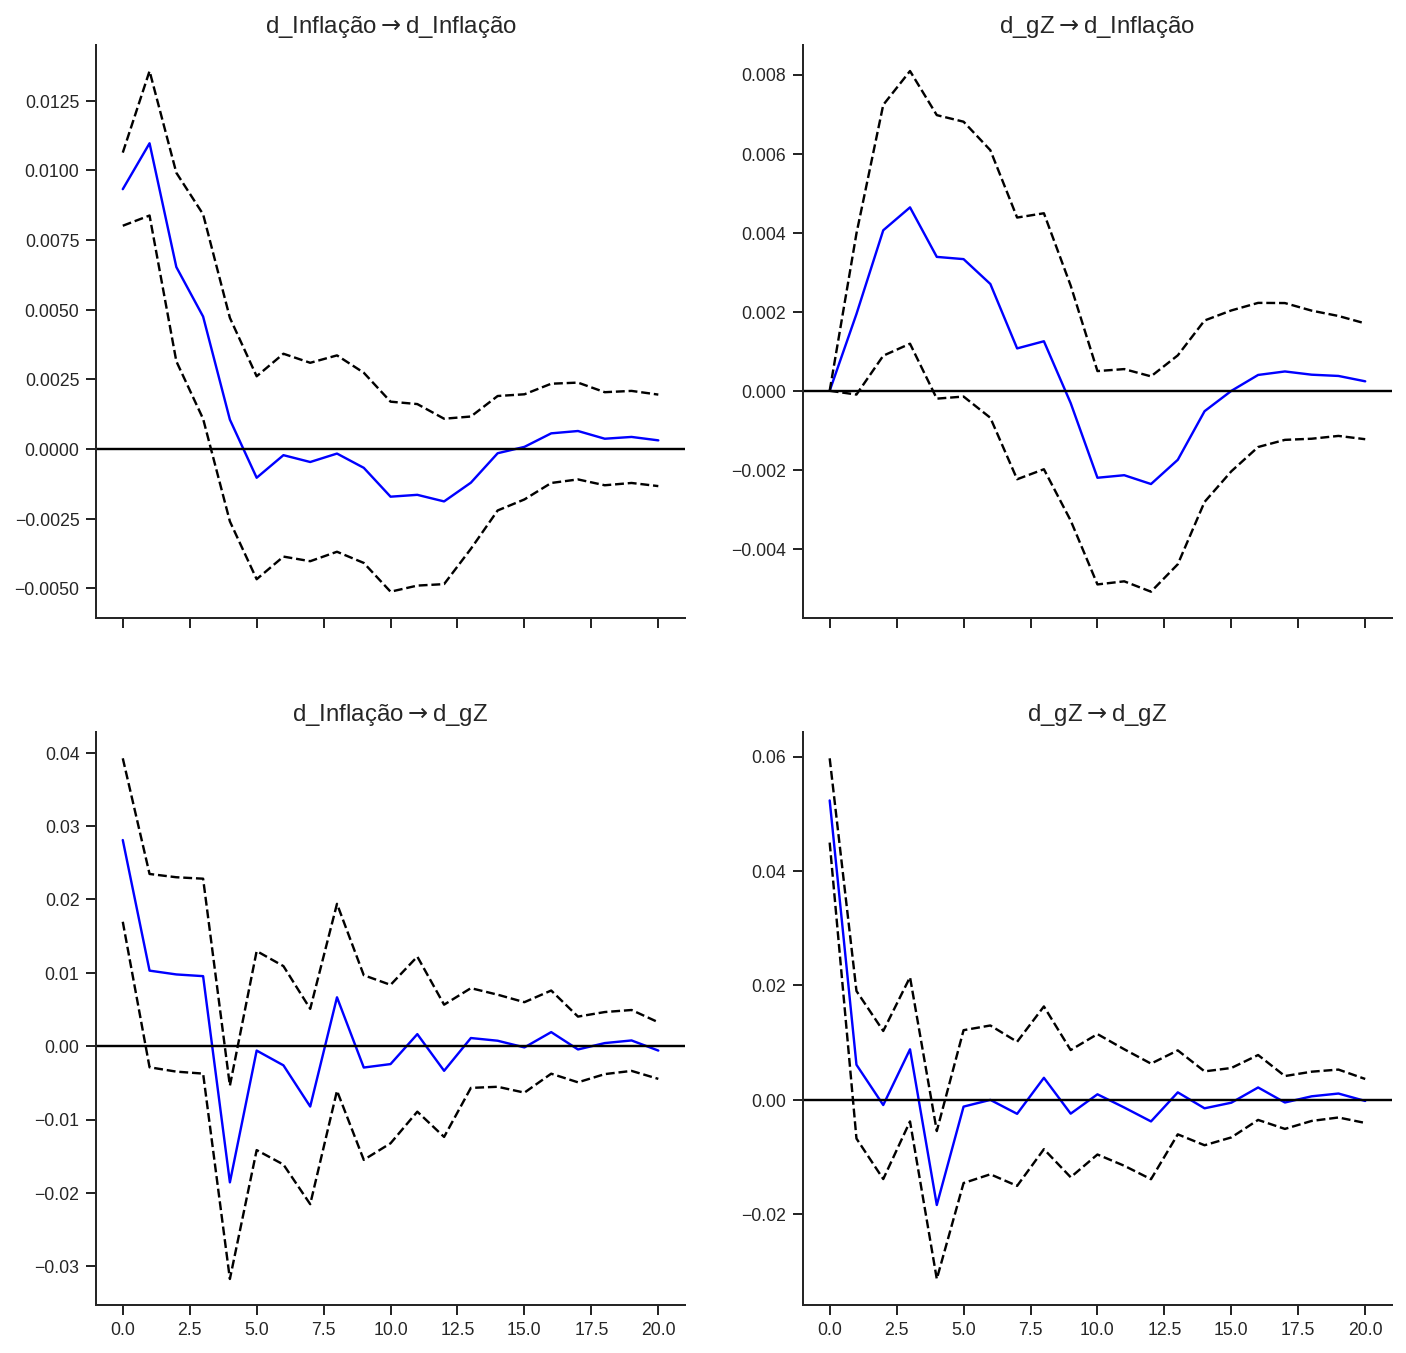

In [38]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

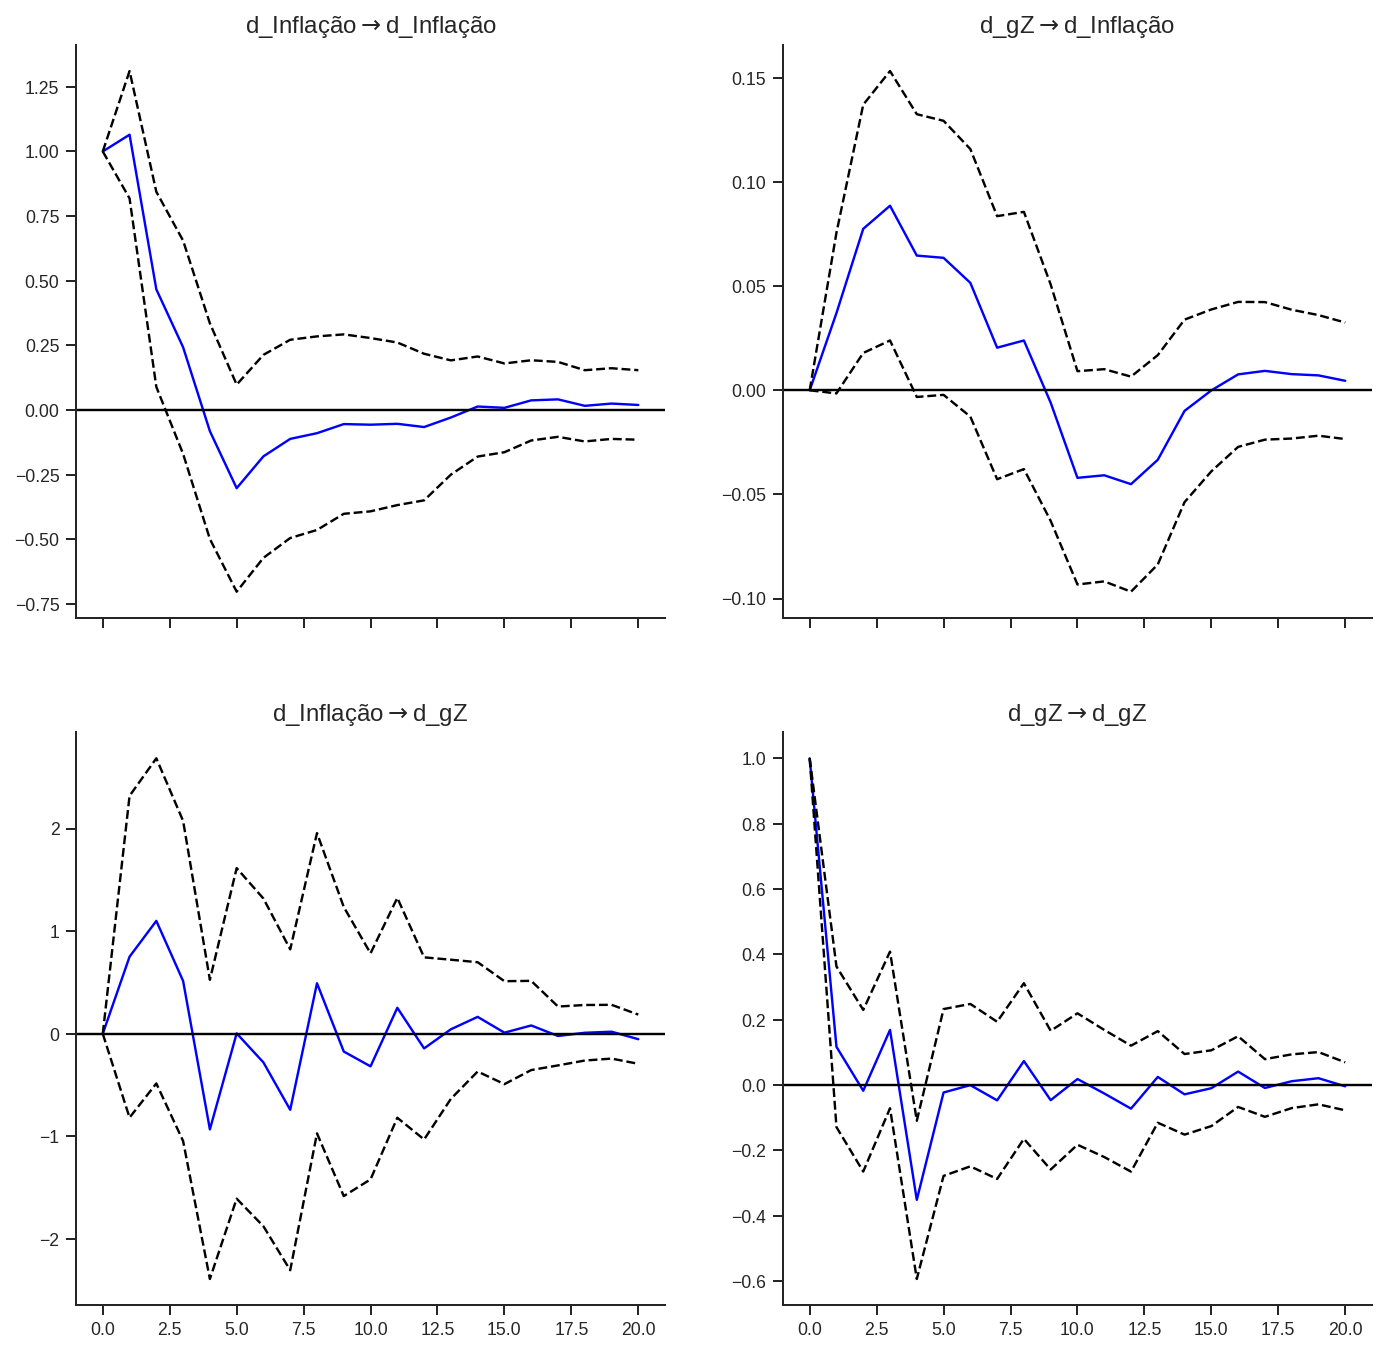

In [39]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

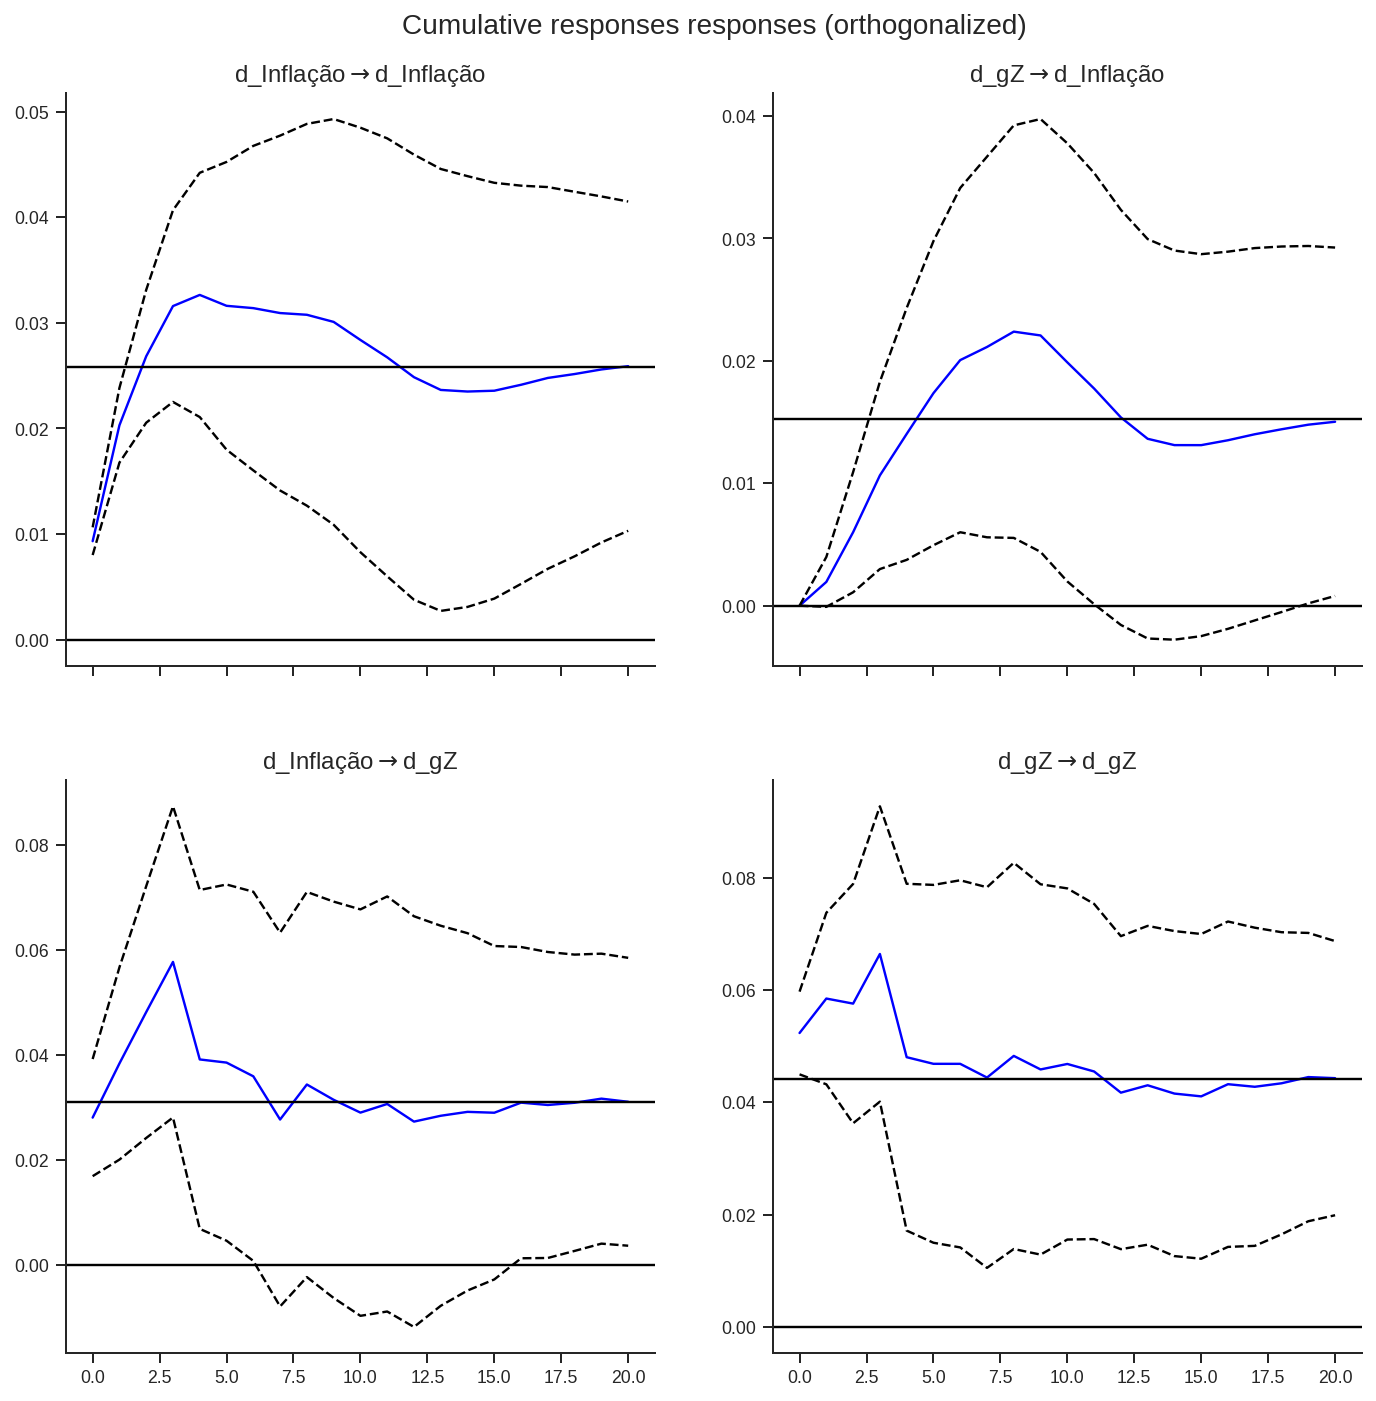

In [40]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

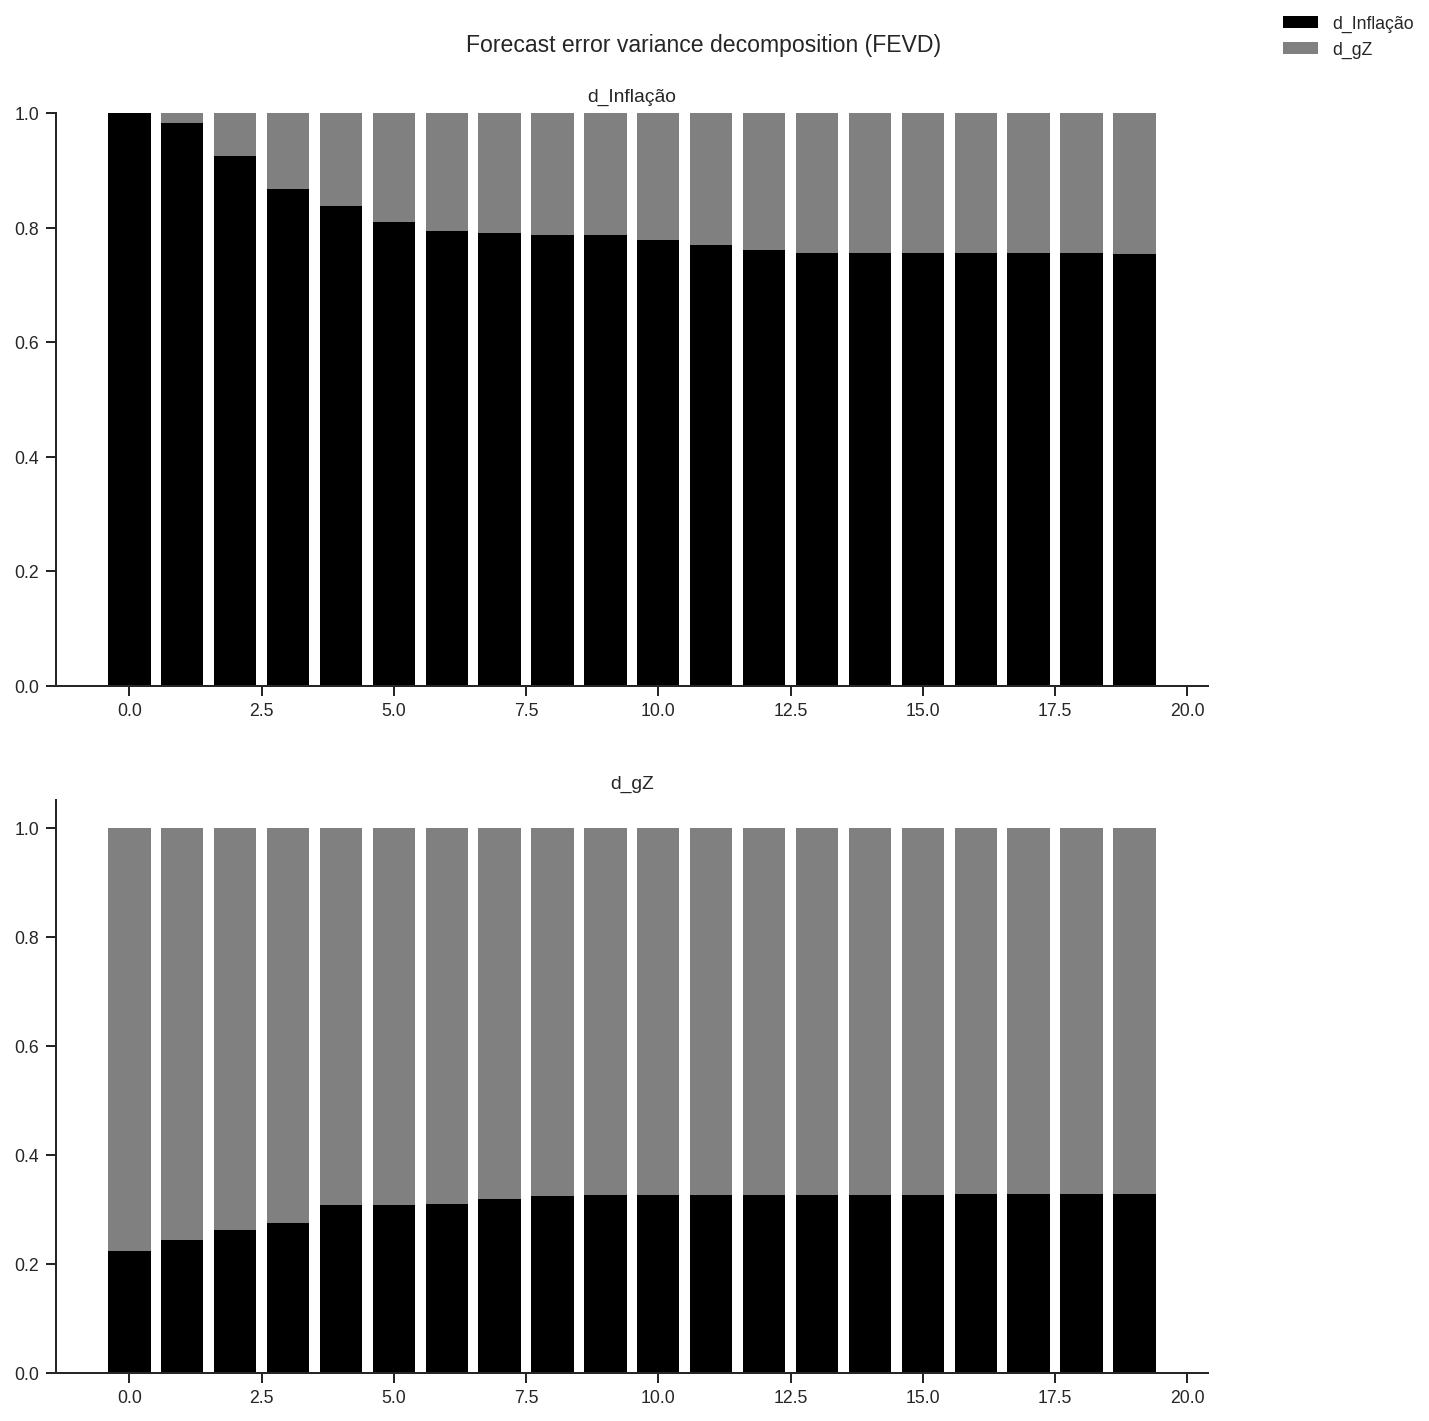

In [41]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)